In [73]:
from load_data import *
from helpers import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold
import xgboost
import shap
from sklearn.decomposition import PCA

In [74]:
price, listings, reviews = load_selected_data()

------------------------------
Selecting Features data...
------------------------------
------------------------------
Loading data...
------------------------------
Data loaded.



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
This pattern has match groups. To actually get the groups, use str.extract.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Text and Open Street Data generated.
Image data loaded.
Have fun implementing your models.
Due to insignificant t-tests we dropped:
['Bathtub', 'Bed linens', 'Breakfast', 'Cleaning before checkout', 'Dishwasher', 'Elevator', 'Hair dryer', 'Indoor fireplace', 'Private entrance', 'Security cameras on property', 'Single level home', 'Stoves_available', 'Refridgerator_available', 'Body_soap_available', 'Garden_backyard_available', 'Children_Entertainment', 'Workspace', 'Gym_available', 'Coffee_machine_available', 'Dryer_available', 'Washer_available', 'Hot_tub_available', 'Pool_available', 'Wifi_available', 'AC_available', 'heating_available', 'Kitchen_available', 'Safe_available', 'Water_location', 'sound_system_available', 'TV_available', 'Outdoor_stuff', 'Game_consoles', 'Baby_friendly', 'Special_stuff', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown', 'property_type_Entire guesthouse', 'proper

# Variable Selection

In [75]:
price_y = price["log_price"]

In [76]:
bin_col = [col for col in listings if np.isin(listings[col].unique(), [0, 1]).all()]

In [77]:
num_col = [col for col in listings if ~np.isin(listings[col].unique(), [0, 1]).all()]

In [78]:
len(listings.columns) == len(num_col) + len(bin_col)

True

In [79]:
listings

,host_since,host_listings_count,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_has_profile_pic,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,Long term stays allowed,Oven_available,Free_parking,Paid_parking,Shampoo_Conditioner_available,Patio_balcony_available,bath_number_0,bath_number_1,bath_number_2,bath_number_3,bath_number_greater3,bedroom_number_1,bedroom_number_2,bedroom_number_3,bedroom_number_greater3,neighbourhood_cleansed_Dublin City,neighbourhood_cleansed_Fingal,neighbourhood_cleansed_South Dublin,property_type_Entire bungalow,property_type_Entire cabin,property_type_Entire condominium (condo),property_type_Entire cottage,property_type_Entire guest suite,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Others,property_type_Private room,property_type_Private room in bungalow,property_type_Private room in cabin,property_type_Private room in condominium (condo),property_type_Private room in cottage,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Private room in townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_location_country_Brazil,host_location_country_Germany,host_location_country_India,host_location_country_Ireland,host_location_country_Israel,host_location_country_Italy,host_location_country_Others,host_location_country_Poland,host_location_country_United Kingdom,host_location_country_United States,bath_kind_Normal,bath_kind_Private,bath_kind_Shared,name_length,description_length,neighborhood_overview_length,host_about_length,prop_of_eng_reviews,mean_compound,mean_negativity,mean_neutrality,mean_positivity,mean_review_length,prop_of_neg_comp,most_neg_compound,most_pos_compound,compound_descr,negativity_descr,neutrality_descr,positivity_descr,compound_neigh_over,negativity_neigh_over,neutrality_neigh_over,positivity_neigh_over,compound_host_ab,negativity_host_ab,neutrality_host_ab,positivity_host_ab,host_name_sounds_trad_irish,host_name_sounds_asia,host_name_sounds_eastern_europe,host_name_sounds_latin_america,host_name_sounds_west,host_name_sounds_rare,in_city,bars,cafes,fast_foods,restaurants,library,university,bus_train_tram_station,bicycle_rentals,parking,taxi,casinos,cinemas,nightclubs,social_amenities,sex_amenities,theatres_artscentre,malls,supermarkets,nearest_sight,2nd_nearest_sight,3rd_nearest_sight,mean_dist_sight,nearest_travel_poss,mean_dist_travel,count,brightness,contrast,no_img_bathroom,no_img_bedroom,no_img_dining,no_img_hallway,no_img_kitchen,no_img_living,no_img_others
0,4112,3.0,53.291780,-6.257920,2,2.0,3,1125,0,0,22,202,227,0,0,3735,639,4.770000,4.820000,4.720000,4.920000,4.660000,4.820000,3,1.82,1,3,3,1125,1125,3.0,1125.0,0,3,0,1.0,1.0,1.0,0.0,1.0,1.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,35,1000,391,285,0.859031,0.886258,0.009793,0.670132,0.311251,323.744493,0.000000,0.000000,0.998300,0.9808,0.000,0.856,0.144,0.7003,0.057,0.820,0.123,0.9786,0.000,0.584,0.416,1,0,0,0,0,0,0,4,5,9,9,1,1,4,0,61,0,0,0,0,0,0,0,2,5,5258.614042,5311.260588,5361.976549,6151.906435,6556.557064,9939.084679,36.0,134.116660,0.982483,1.0,9.0,2.0,3.0,1.0,2.0,18.0
1,4112,3.0,53.292090,-6.256240,2,1.0,3,21,0,0,2

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(listings[num_col])
stand_values = scaler.transform(listings[num_col])
listings[num_col] = stand_values

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

We should take the correlation of the variables into account. Therefore we need different approaches dependent on the scale of variables
- pearson: numeric and numeric 
- jaccard: binary and binary
- point-biserial: binary and numeric

In [81]:
listings.columns.values

array(['host_since', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'host_has_profile_pic', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms',
       'Long term stays allowed', 'Oven_available'

In [82]:
# sanity check
len(num_col + bin_col) == len(listings.columns)

True

## Pearson Correlation

In [83]:
numerical_df = listings.filter(num_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = numerical_df.columns

sel.fit_transform(numerical_df)
num_col = sel.get_feature_names_out()
print(str(len(numerical_df.columns) - len(num_col)) + " variables have been removed")
numerical_df = numerical_df.filter(num_col)

0 variables have been removed


In [84]:
PEARSON = np.abs(numerical_df.corr())

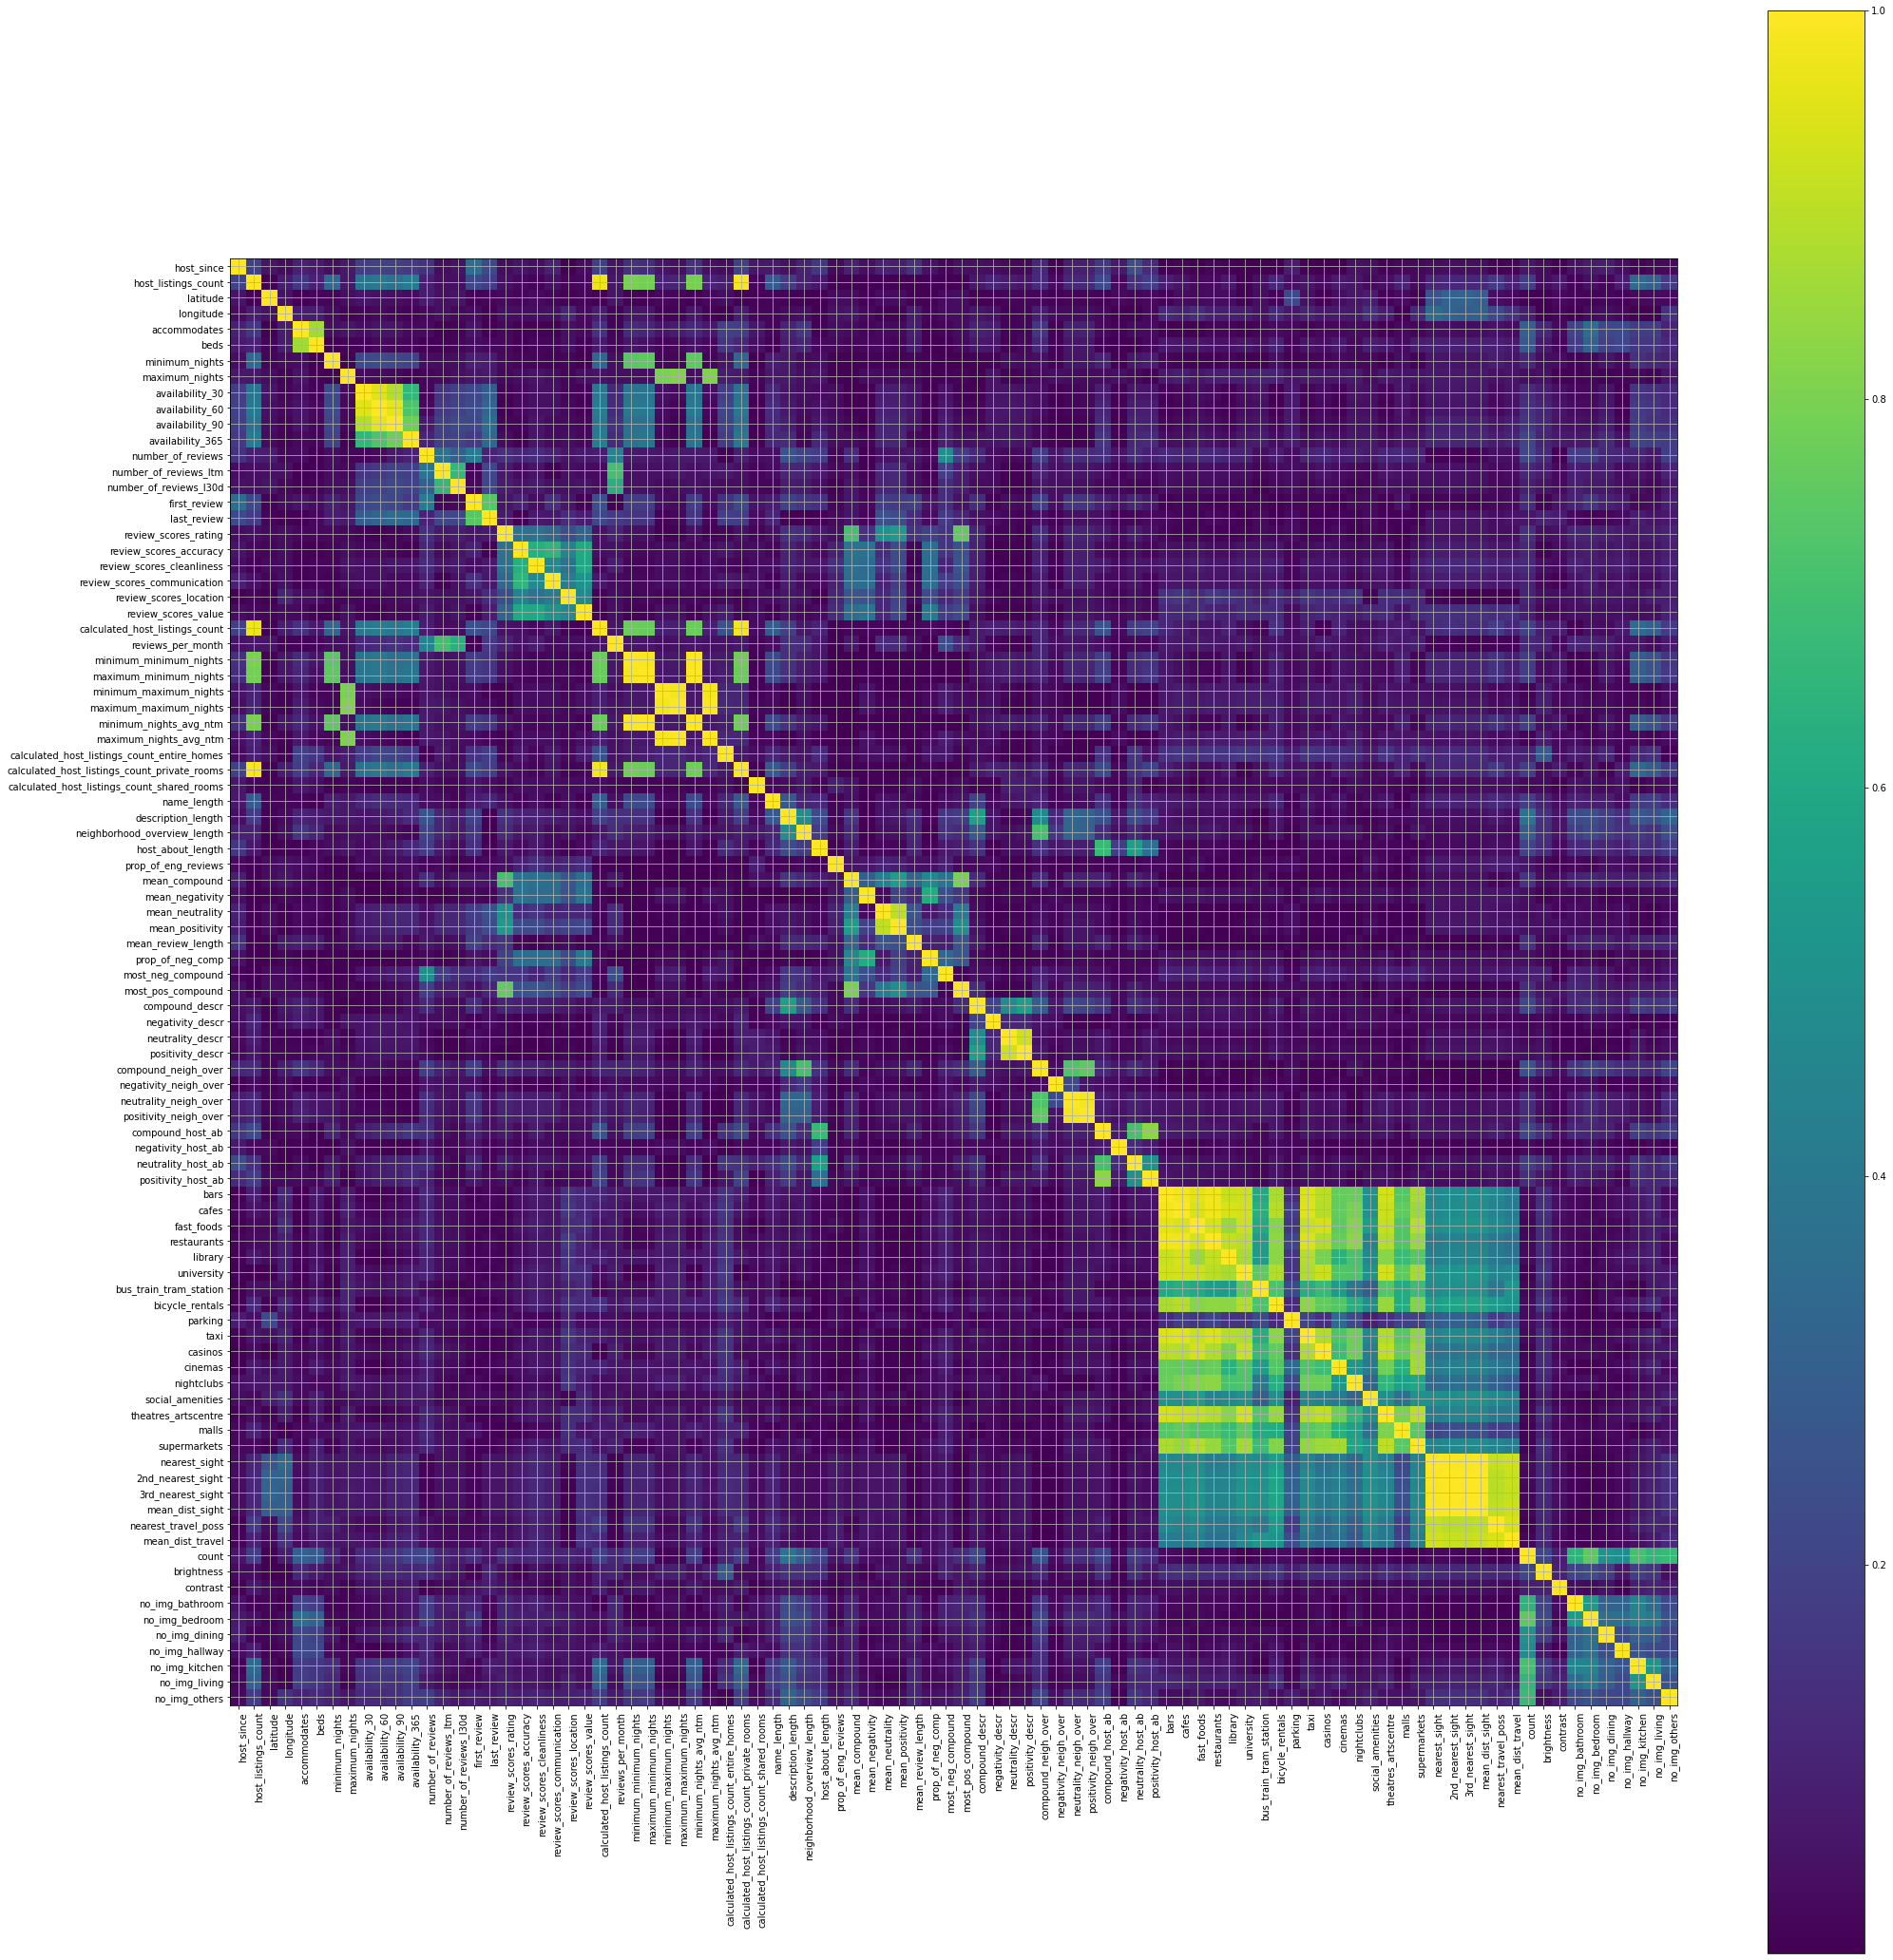

In [85]:
fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(np.abs(listings.filter(num_col).corr()))
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(num_col)))
ax.set_xticklabels(labels=num_col)
ax.set_yticks(np.arange(len(num_col)))
ax.set_yticklabels(labels=num_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.tight_layout()
plt.show()

## Binary Features

Let's remove features which don't have enough variance or in other words which are either 0 or 1 in most of the cases 
- https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f







In [86]:
binary_df = listings.filter(bin_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = binary_df.columns

sel.fit_transform(binary_df)
binary_col = sel.get_feature_names_out()
print(str(len(binary_df.columns) - len(binary_col)) + " variables have been removed")
binary_df = binary_df.filter(binary_col)

38 variables have been removed


### Jaccard Correlation

At first lets define a function that calculates the Jaccard Correlation coefficient

In [87]:
def jac(x,y):
    a = ((x == 1) == (y == 1)).sum()
    b = ((x == 1) == (y == 0)).sum()
    c = ((x == 0) == (y == 1)).sum()
    #d = ((x == 0) == (y == 0)).sum()

    j = a/(a+b+c)

    return j

Now calculate the coefficient for each combination of binary covariables

In [88]:
# init matrix
A = np.zeros((len(binary_col), len(binary_col)))

for i, a in enumerate(binary_col):
    for j, b in enumerate(binary_col):
        A[i,j] = jac(binary_df[a], binary_df[b])

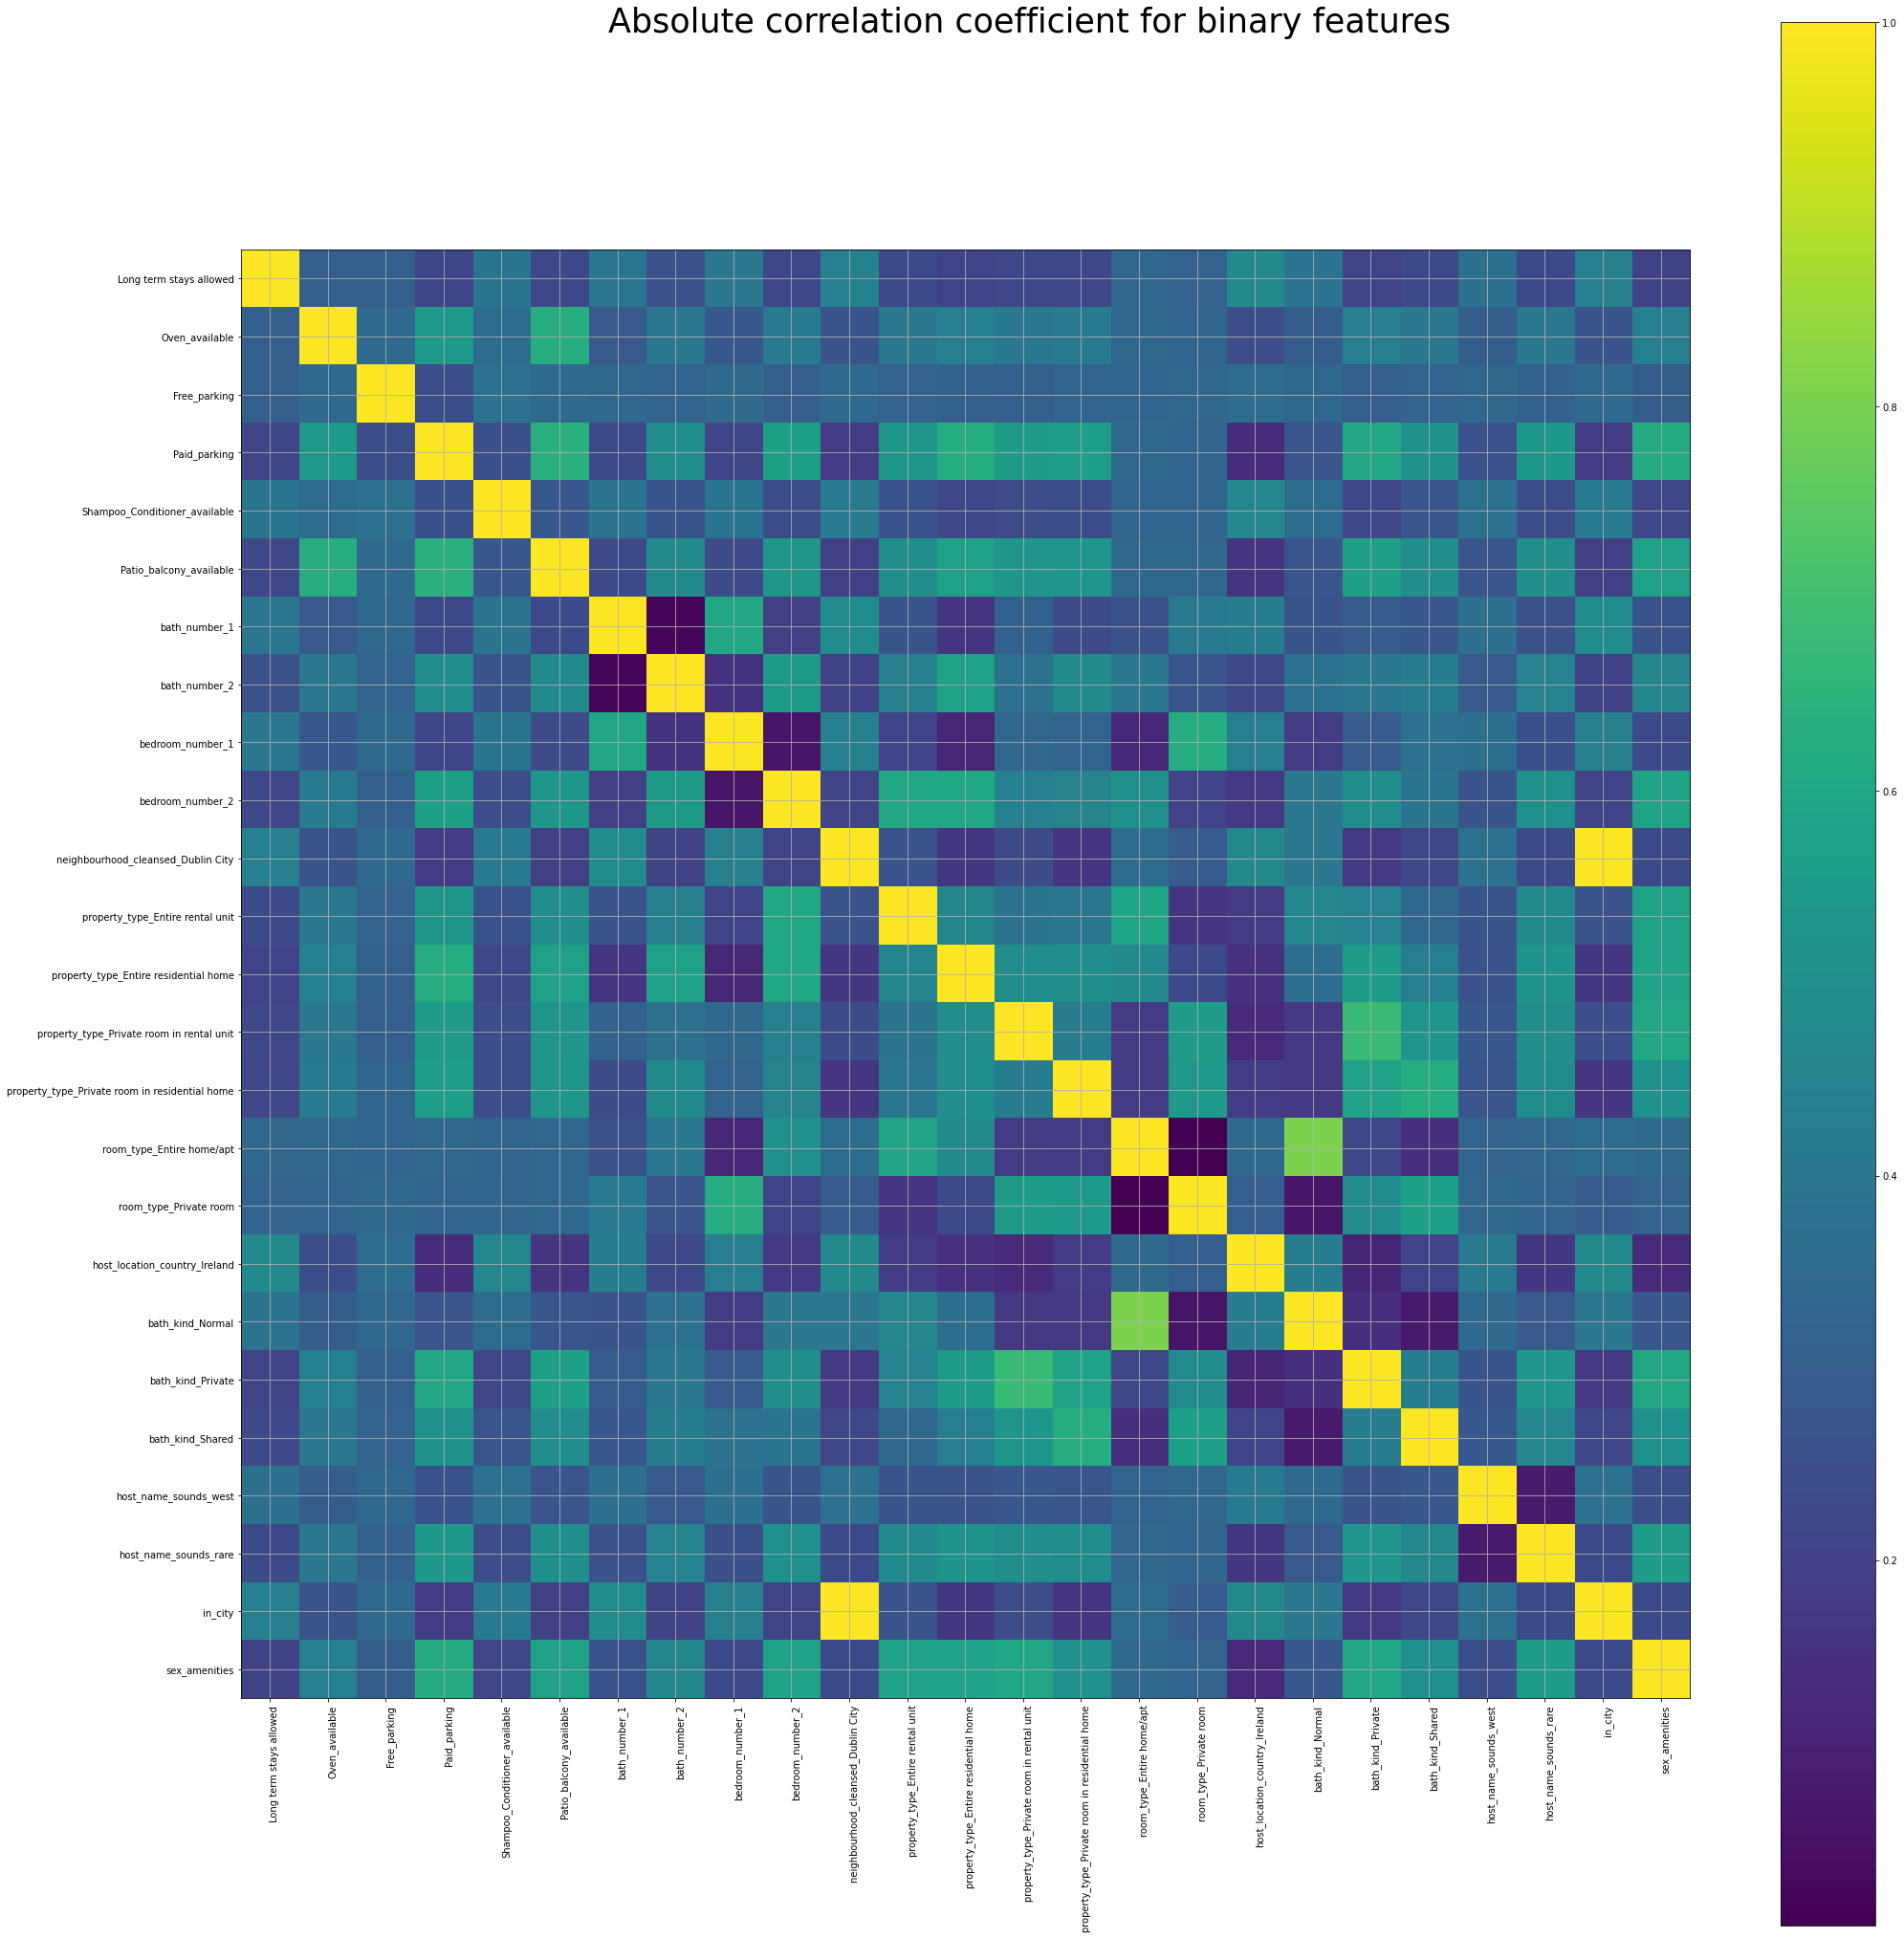

In [89]:
JACCARD = pd.DataFrame(np.abs(A))
jac_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(jac_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(binary_col)))
ax.set_xticklabels(labels = binary_col)
ax.set_yticks(np.arange(len(binary_col)))
ax.set_yticklabels(labels = binary_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary features", fontsize = 35)
fig.tight_layout()
plt.show()

## Point-Biserial

- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html

In [90]:
numerical_df.isna().sum()[numerical_df.isna().sum()>0]

Series([], dtype: int64)

In [91]:
binaries = binary_df
numericals = numerical_df

# init matrix
A = np.zeros((len(binaries.columns), len(numericals.columns)))
P = np.zeros((len(binaries.columns), len(numericals.columns)))

for i, a in enumerate(binaries.columns):
    for j, b in enumerate(numericals.columns):
        A[i,j], P[i,j] = stats.pointbiserialr(binaries[a], numericals[b])

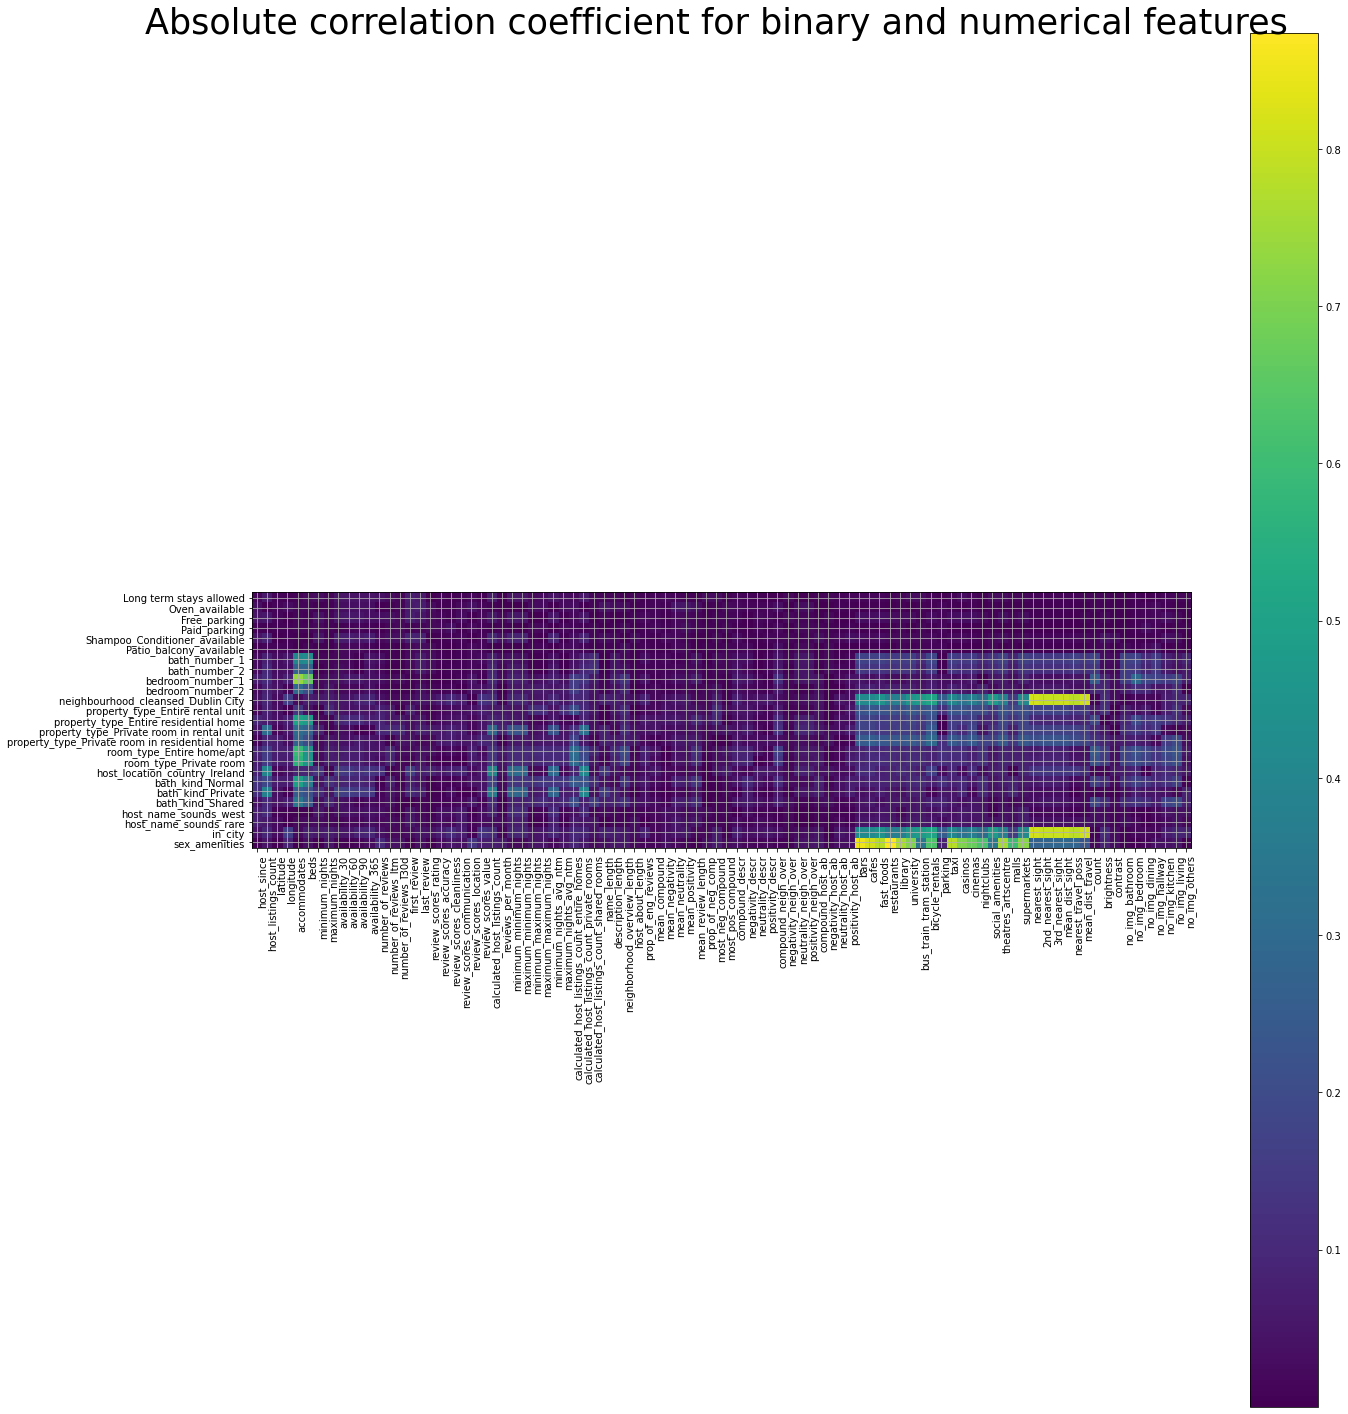

In [92]:
BISERIAL = pd.DataFrame(np.abs(A))
bis_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (20,20))
im = ax.imshow(bis_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(numericals.columns)))
ax.set_xticklabels(labels=numericals)
ax.set_yticks(np.arange(len(binaries.columns)))
ax.set_yticklabels(labels=binaries)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

## Combine all correlation coefficients in a single matrix

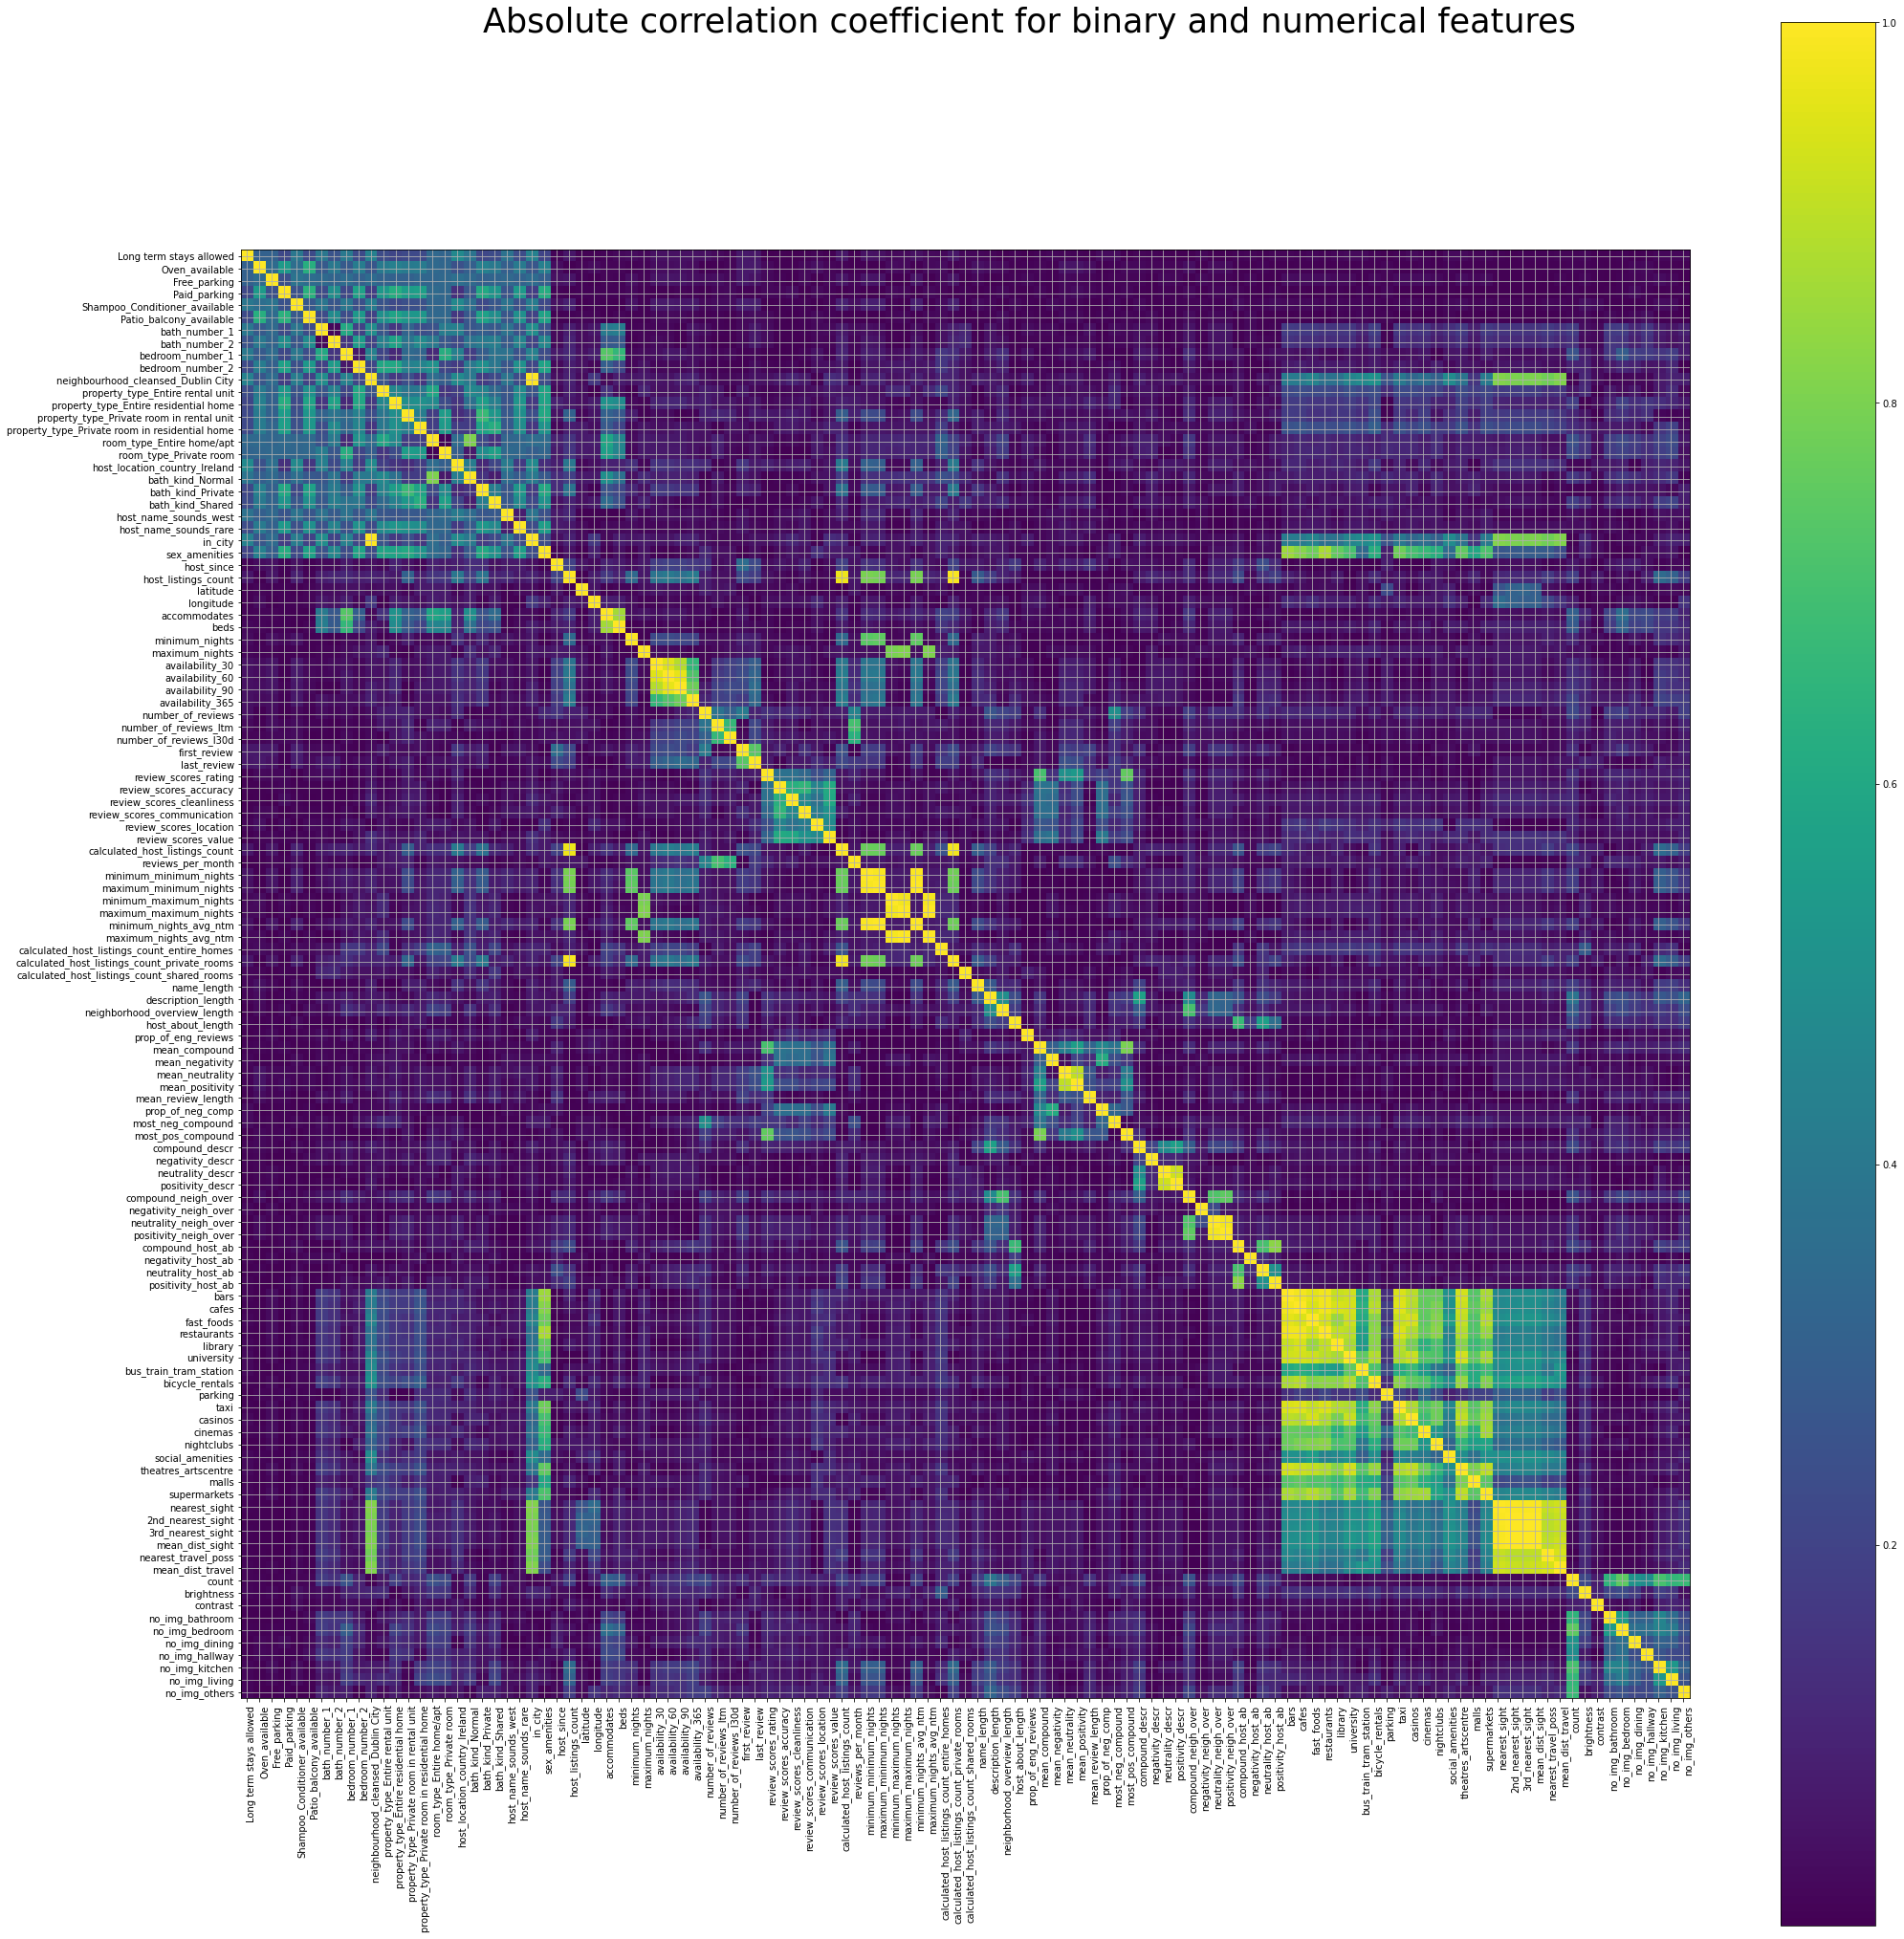

In [93]:
all_col = list(binary_col) + list(num_col)
listings_compl = listings.filter(all_col)
C = np.zeros((len(all_col), len(all_col)))

C[:len(binary_col),:len(binary_col)] = JACCARD
C[len(binary_col):,len(binary_col):] = PEARSON
C[len(binary_col):,:len(binary_col)] = BISERIAL.T
C[:len(binary_col),len(binary_col):] = BISERIAL

C_df = pd.DataFrame(np.abs(C))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(C_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(C_df.columns)))
ax.set_xticklabels(labels=all_col)
ax.set_yticks(np.arange(len(C_df.columns)))
ax.set_yticklabels(labels=all_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

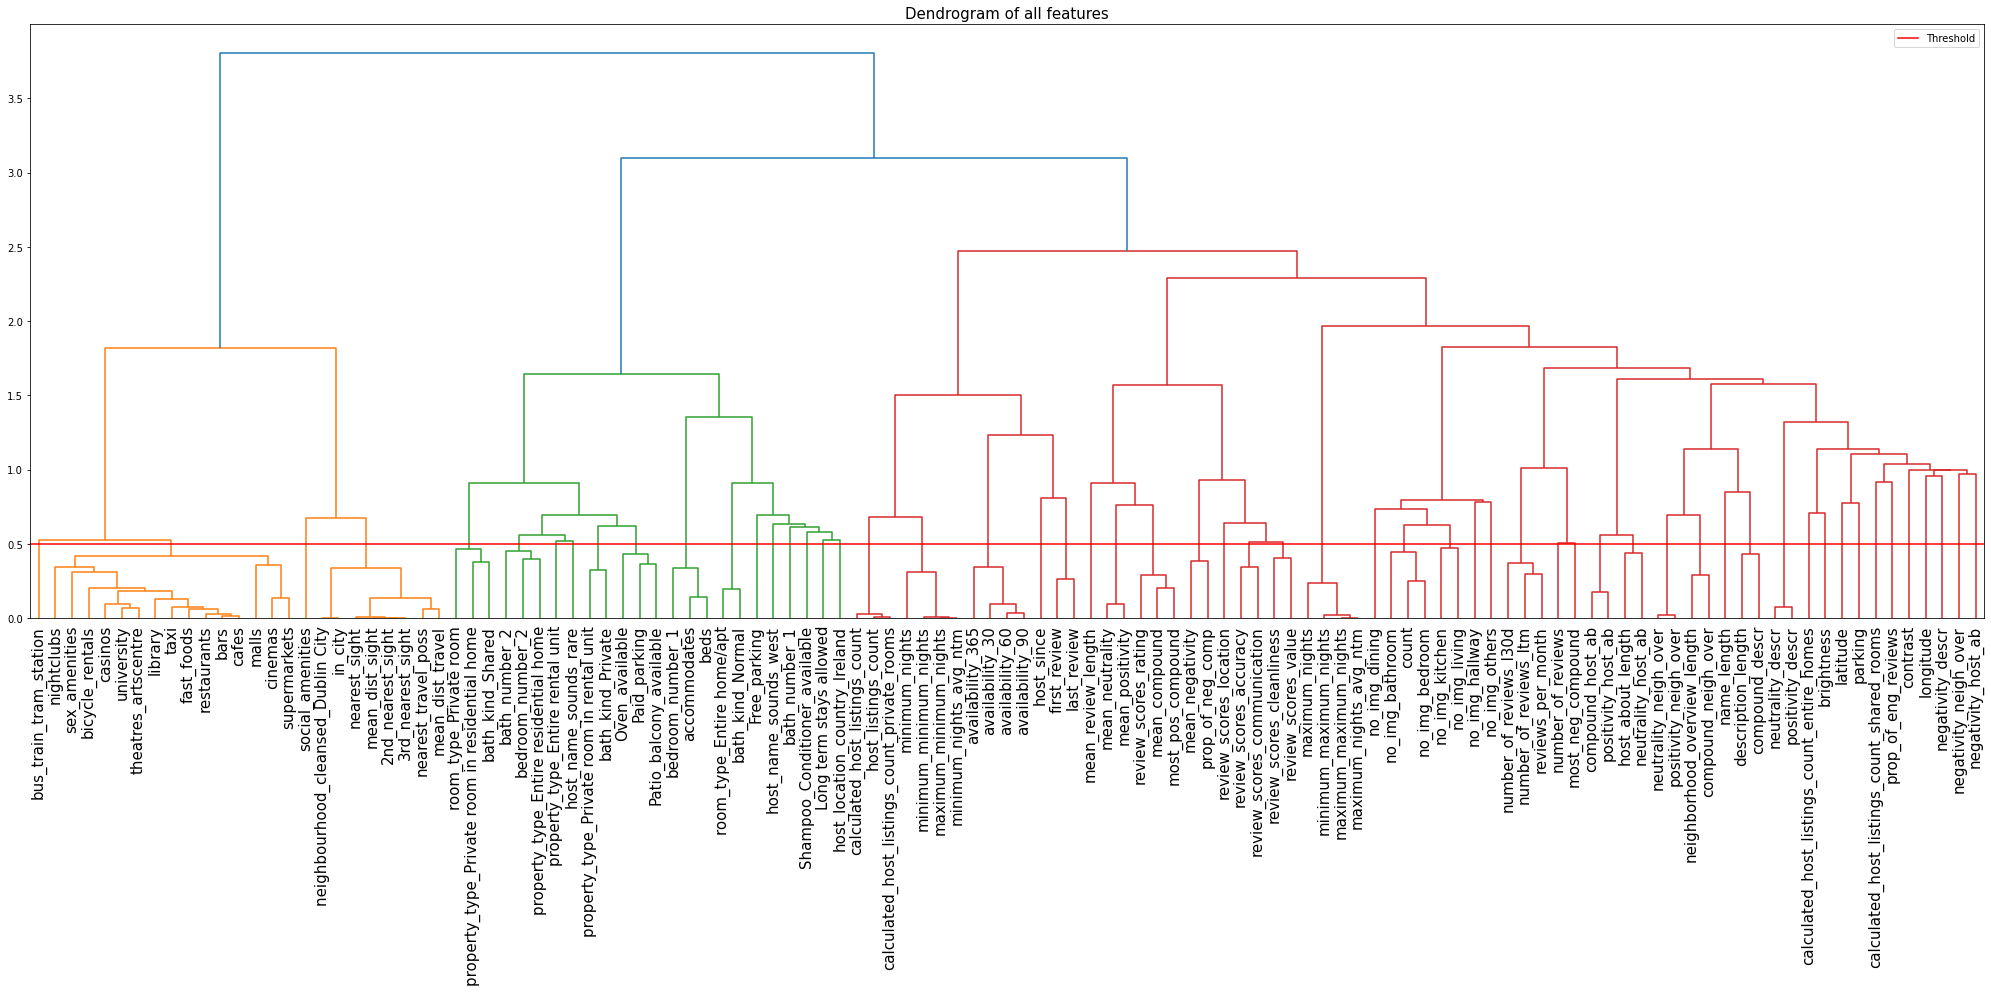

In [94]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr = C
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

The dendrogram shows which features are so similar that it might be reasonable to keep only one of those variables. We can set our threshold around 0.5 and explore the clusters we find below:

### For threshold = 0.5
1. keep room type Entire home/apt
3. keep kitchen available
4. combine to bathroom essentials 
5. combine stove, oven and refridgerator to large kitchen appliances
6. combine patio balcony and garden to outside areas
7. keep room type private room 
8. keep breakfast 
9. keep property type private room in rental unit
10. keep property type entire residential home


In [95]:
# PCA for city-life
city_life = ["nightclubs", "sex_amenities", "bicycle_rentals", "casinos", "university", 
             "theatres_artscentre", "library", "taxi", "fast_foods", "restaurants", "bars",
             "cafes", "malls", "cinemas", "supermarkets"]
             
city_life_df = listings_compl[city_life]
listings_compl["city_life_pca"] = PCA(n_components = 1).fit_transform(city_life_df)
listings_compl = drop_col(listings_compl, city_life, regex = False)

# PCA for touristic and travel
travel_touristic = ["neighbourhood_cleansed_Dublin City", "in_city", "nearest_sight", "mean_dist_sight", "2nd_nearest_sight",
                    "3rd_nearest_sight", "nearest_travel_poss", "mean_dist_travel"]

travel_touristic_df = listings_compl[travel_touristic]

listings_compl["travel_touristic_pca"] = PCA(n_components = 1).fit_transform(travel_touristic_df)
listings_compl = drop_col(listings_compl, travel_touristic, regex = False)

In [96]:
listings_compl = drop_col(listings_compl, ["room_type_Private room", "bath_kind_Shared"], regex = False)
listings_compl = drop_col(listings_compl, ["bath_number_2","bedroom_number_2"], regex = False)
listings_compl = drop_col(listings_compl, ["bath_kind_Private"], regex = False)
listings_compl = drop_col(listings_compl, ["Paid_parking", "Patio_balcony_available"], regex = False)
listings_compl = drop_col(listings_compl, ["bath_kind_Normal"], regex = False)

# PCA for accommodation size
acco = ["bedroom_number_1", "accommodates", "beds"]

accommodation_size_df = listings_compl[acco]

listings_compl["accommodation_size_pca"] = PCA(n_components = 1).fit_transform(accommodation_size_df)
listings_compl = drop_col(listings_compl, acco, regex = False)

In [97]:
listings_compl = drop_col(listings_compl, ["first_review"], regex = False)
listings_compl = drop_col(listings_compl, ["mean_neutrality"], regex = False)
listings_compl = drop_col(listings_compl, ["mean_negativity"], regex = False)
listings_compl = drop_col(listings_compl, ["review_scores_communication", "review_scores_cleanliness"], regex = False)
listings_compl = drop_col(listings_compl, ["no_img_bathroom", "no_img_bedroom"], regex = False)
listings_compl = drop_col(listings_compl, ["no_img_living"], regex = False)
listings_compl = drop_col(listings_compl, ["positivity_host_ab"], regex = False)
listings_compl = drop_col(listings_compl, ["neutrality_host_ab"], regex = False)
listings_compl = drop_col(listings_compl, ["neutrality_neigh_over"], regex = False)
listings_compl = drop_col(listings_compl, ["neighborhood_overview_length"], regex = False)
listings_compl = drop_col(listings_compl, ["description_length"], regex = False)
listings_compl = drop_col(listings_compl, ["neutrality_descr"], regex = False)

# PCA for host listings counts
host_listings = ["calculated_host_listings_count", "host_listings_count", "calculated_host_listings_count_private_rooms"]

host_listings_df = listings_compl[host_listings]
listings_compl["host_listings_pca"] = PCA(n_components = 1).fit_transform(host_listings_df)
listings_compl = drop_col(listings_compl, host_listings, regex = False)

# PCA for minimum nights
min_nights = ["minimum_nights", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_nights_avg_ntm"]

min_nights_df = listings_compl[min_nights]

listings_compl["min_nights_pca"] = PCA(n_components = 1).fit_transform(min_nights_df)
listings_compl = drop_col(listings_compl, min_nights, regex = False)

# PCA for availability
avail = ["availability_365", "availability_30", "availability_60", "availability_90"]

avail_df = listings_compl[avail]

listings_compl["availability_pca"] = PCA(n_components = 1).fit_transform(avail_df)
listings_compl = drop_col(listings_compl, avail, regex = False)

# PCA for review total score
review_total_scores = ["review_scores_rating", "mean_compound", "most_pos_compound"]

review_total_scores_df = listings_compl[review_total_scores]

listings_compl["review_total_pca"] = PCA(n_components = 1).fit_transform(review_total_scores_df)
listings_compl = drop_col(listings_compl, review_total_scores, regex = False)

# PCA for review scores

# PCA for maximum nights
max_nights = ["maximum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "maximum_nights_avg_ntm"]

max_nights_df = listings_compl[max_nights]

listings_compl["max_nights_pca"] = PCA(n_components = 1).fit_transform(max_nights_df)
listings_compl = drop_col(listings_compl, max_nights, regex = False)

# PCA for amount of reviews
review_amount = ["number_of_reviews_l30d", "number_of_reviews_ltm", "reviews_per_month"]

review_amount_df = listings_compl[review_amount]

listings_compl["review_amount_pca"] = PCA(n_components = 1).fit_transform(review_amount_df)
listings_compl = drop_col(listings_compl, review_amount, regex = False)


# Dendrogram after cleaning

In [98]:
num_col_compl = [col for col in listings_compl if ~np.isin(listings_compl[col].unique(), [0, 1]).all()]
bin_col_compl = [col for col in listings_compl if np.isin(listings_compl[col].unique(), [0, 1]).all()]

In [99]:
numerical_df2 = listings_compl.filter(num_col_compl)
binary_df2 = listings_compl.filter(bin_col_compl)

PEARSON2 = np.abs(numerical_df2.corr())

# init matrix
A2 = np.zeros((len(bin_col_compl), len(bin_col_compl)))

for i, a in enumerate(bin_col_compl):
    for j, b in enumerate(bin_col_compl):
        A2[i,j] = jac(binary_df2[a], binary_df2[b])

JACCARD2 = pd.DataFrame(np.abs(A2))

binaries2 = binary_df2
numericals2 = numerical_df2

# init matrix
A3 = np.zeros((len(binaries2.columns), len(numericals2.columns)))
P2 = np.zeros((len(binaries2.columns), len(numericals2.columns)))

for i, a in enumerate(binaries2.columns):
    for j, b in enumerate(numericals2.columns):
        A3[i,j], P2[i,j] = stats.pointbiserialr(binaries2[a], numericals2[b])

BISERIAL2 = pd.DataFrame(np.abs(A3))

In [100]:
all_col_compl = bin_col_compl + num_col_compl
C2 = np.zeros((len(all_col_compl), len(all_col_compl)))

C2[:len(bin_col_compl),:len(bin_col_compl)] = JACCARD2
C2[len(bin_col_compl):,len(bin_col_compl):] = PEARSON2
C2[len(bin_col_compl):,:len(bin_col_compl)] = BISERIAL2.T
C2[:len(bin_col_compl),len(bin_col_compl):] = BISERIAL2

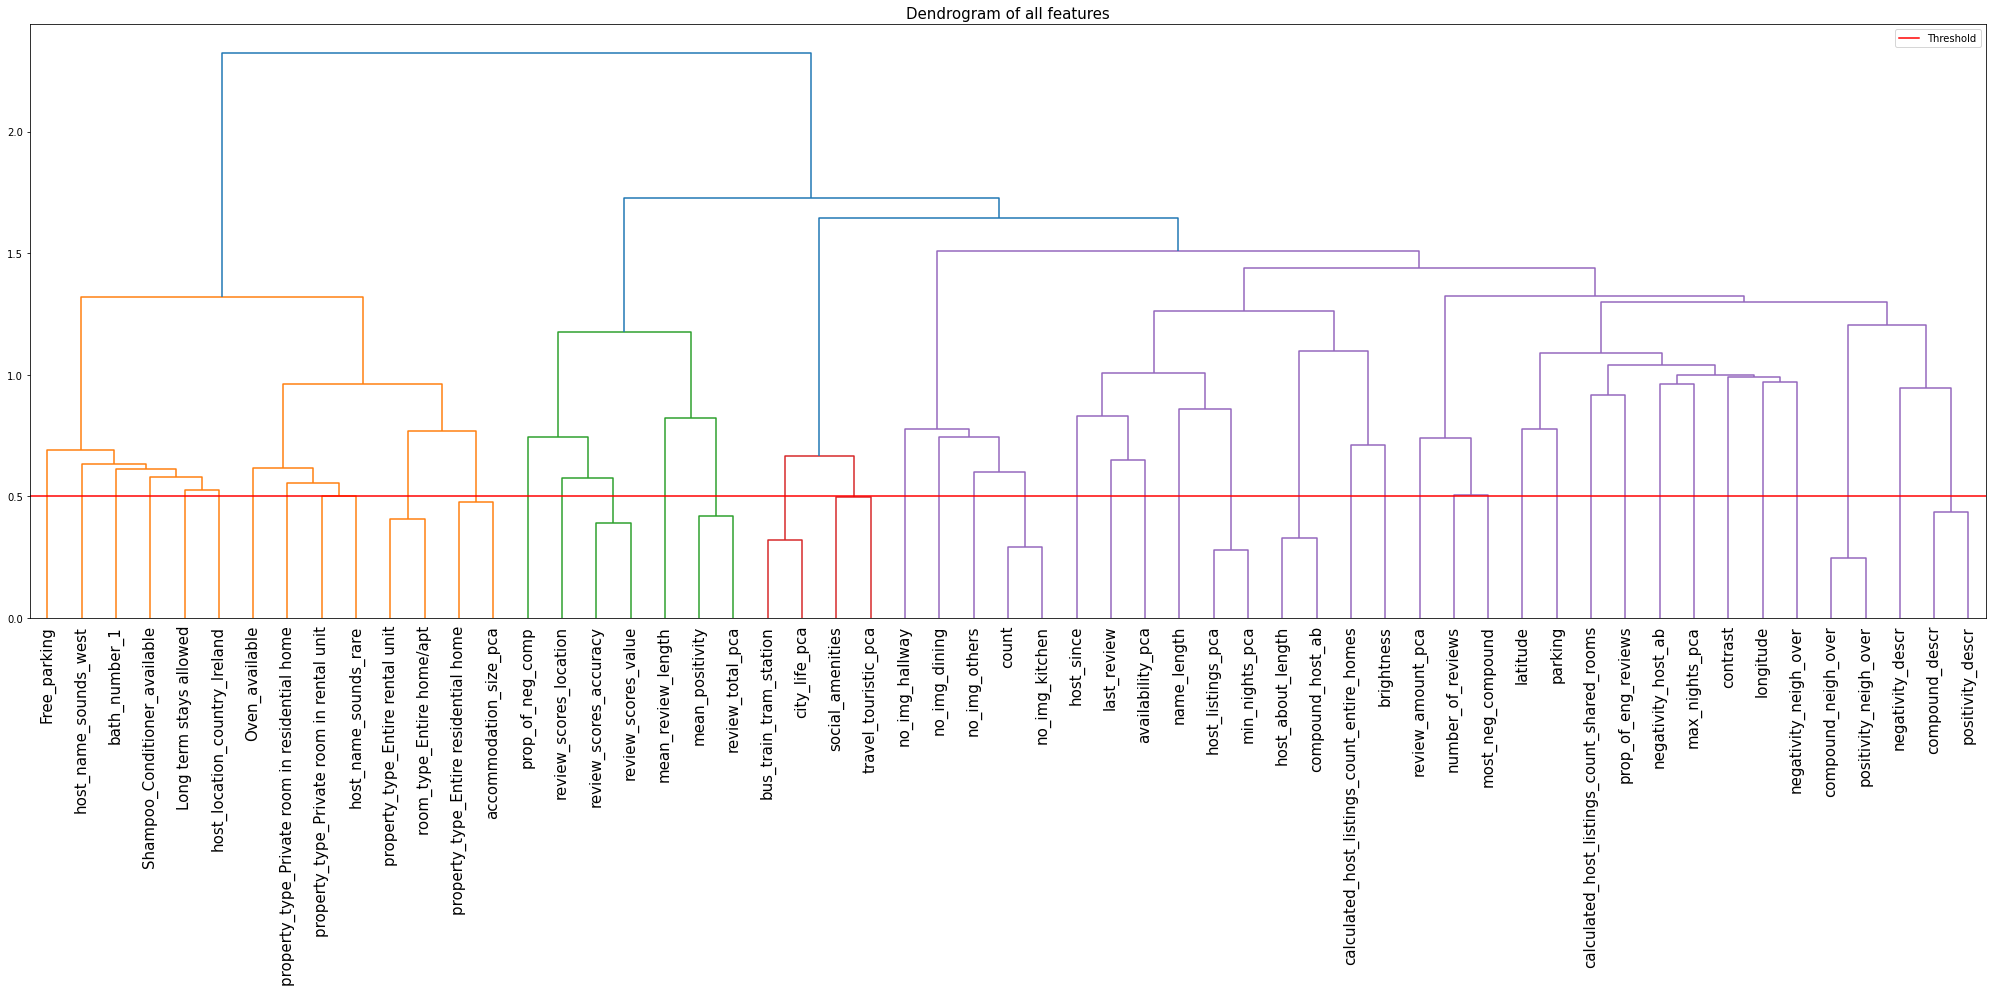

In [101]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr2 = C2
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr2)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col_compl, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

# Decide again for Distance < 0.5

In [103]:
# host_name_sounds_rare or property_type_Private room in renta unit  - keep?

# property_type_Entire rental unit or room_type_Entire_home/apt
listings_compl = drop_col(listings_compl, ["room_type_Entire home/apt"], regex = False)

# property_type_Entire residential home or accomodation_size_pca
listings_compl = drop_col(listings_compl, ["property_type_Entire residential home"], regex = False)

# review_scores_accuracy or review_scores_value
listings_compl = drop_col(listings_compl, ["review_scores_value"], regex = False)

# mean_positivity or review_total_pca
listings_compl = drop_col(listings_compl, ["mean_positivity"], regex = False)

# bus_train_tram_station or city_life_pca
listings_compl = drop_col(listings_compl, ["bus_train_tram_station"], regex = False)

# social_amenities or travel_touristic_pca
listings_compl = drop_col(listings_compl, ["social_amenities"], regex = False)

# count or no_img_kitchen
listings_compl = drop_col(listings_compl, ["no_img_kitchen"], regex = False)

# host_listings_pca or min_nights_pca
listings_compl = drop_col(listings_compl, ["min_nights_pca"], regex = False)

# host_about_length or compound_host_ab
listings_compl = drop_col(listings_compl, ["host_about_length"], regex = False)

# number of_reviews or most_neg_compound - keep?

# compound_neigh_over or positivity_neigh_over
listings_compl = drop_col(listings_compl, ["positivity_neigh_over"], regex = False)

# compound_decsr or positivity_descr
listings_compl = drop_col(listings_compl, ["positivity_descr"], regex = False)


In [104]:
num_col_compl = [col for col in listings_compl if ~np.isin(listings_compl[col].unique(), [0, 1]).all()]
bin_col_compl = [col for col in listings_compl if np.isin(listings_compl[col].unique(), [0, 1]).all()]

In [105]:
numerical_df2 = listings_compl.filter(num_col_compl)
binary_df2 = listings_compl.filter(bin_col_compl)

PEARSON2 = np.abs(numerical_df2.corr())

# init matrix
A2 = np.zeros((len(bin_col_compl), len(bin_col_compl)))

for i, a in enumerate(bin_col_compl):
    for j, b in enumerate(bin_col_compl):
        A2[i,j] = jac(binary_df2[a], binary_df2[b])

JACCARD2 = pd.DataFrame(np.abs(A2))

binaries2 = binary_df2
numericals2 = numerical_df2

# init matrix
A3 = np.zeros((len(binaries2.columns), len(numericals2.columns)))
P2 = np.zeros((len(binaries2.columns), len(numericals2.columns)))

for i, a in enumerate(binaries2.columns):
    for j, b in enumerate(numericals2.columns):
        A3[i,j], P2[i,j] = stats.pointbiserialr(binaries2[a], numericals2[b])

BISERIAL2 = pd.DataFrame(np.abs(A3))

In [106]:
all_col_compl = bin_col_compl + num_col_compl
C2 = np.zeros((len(all_col_compl), len(all_col_compl)))

C2[:len(bin_col_compl),:len(bin_col_compl)] = JACCARD2
C2[len(bin_col_compl):,len(bin_col_compl):] = PEARSON2
C2[len(bin_col_compl):,:len(bin_col_compl)] = BISERIAL2.T
C2[:len(bin_col_compl),len(bin_col_compl):] = BISERIAL2

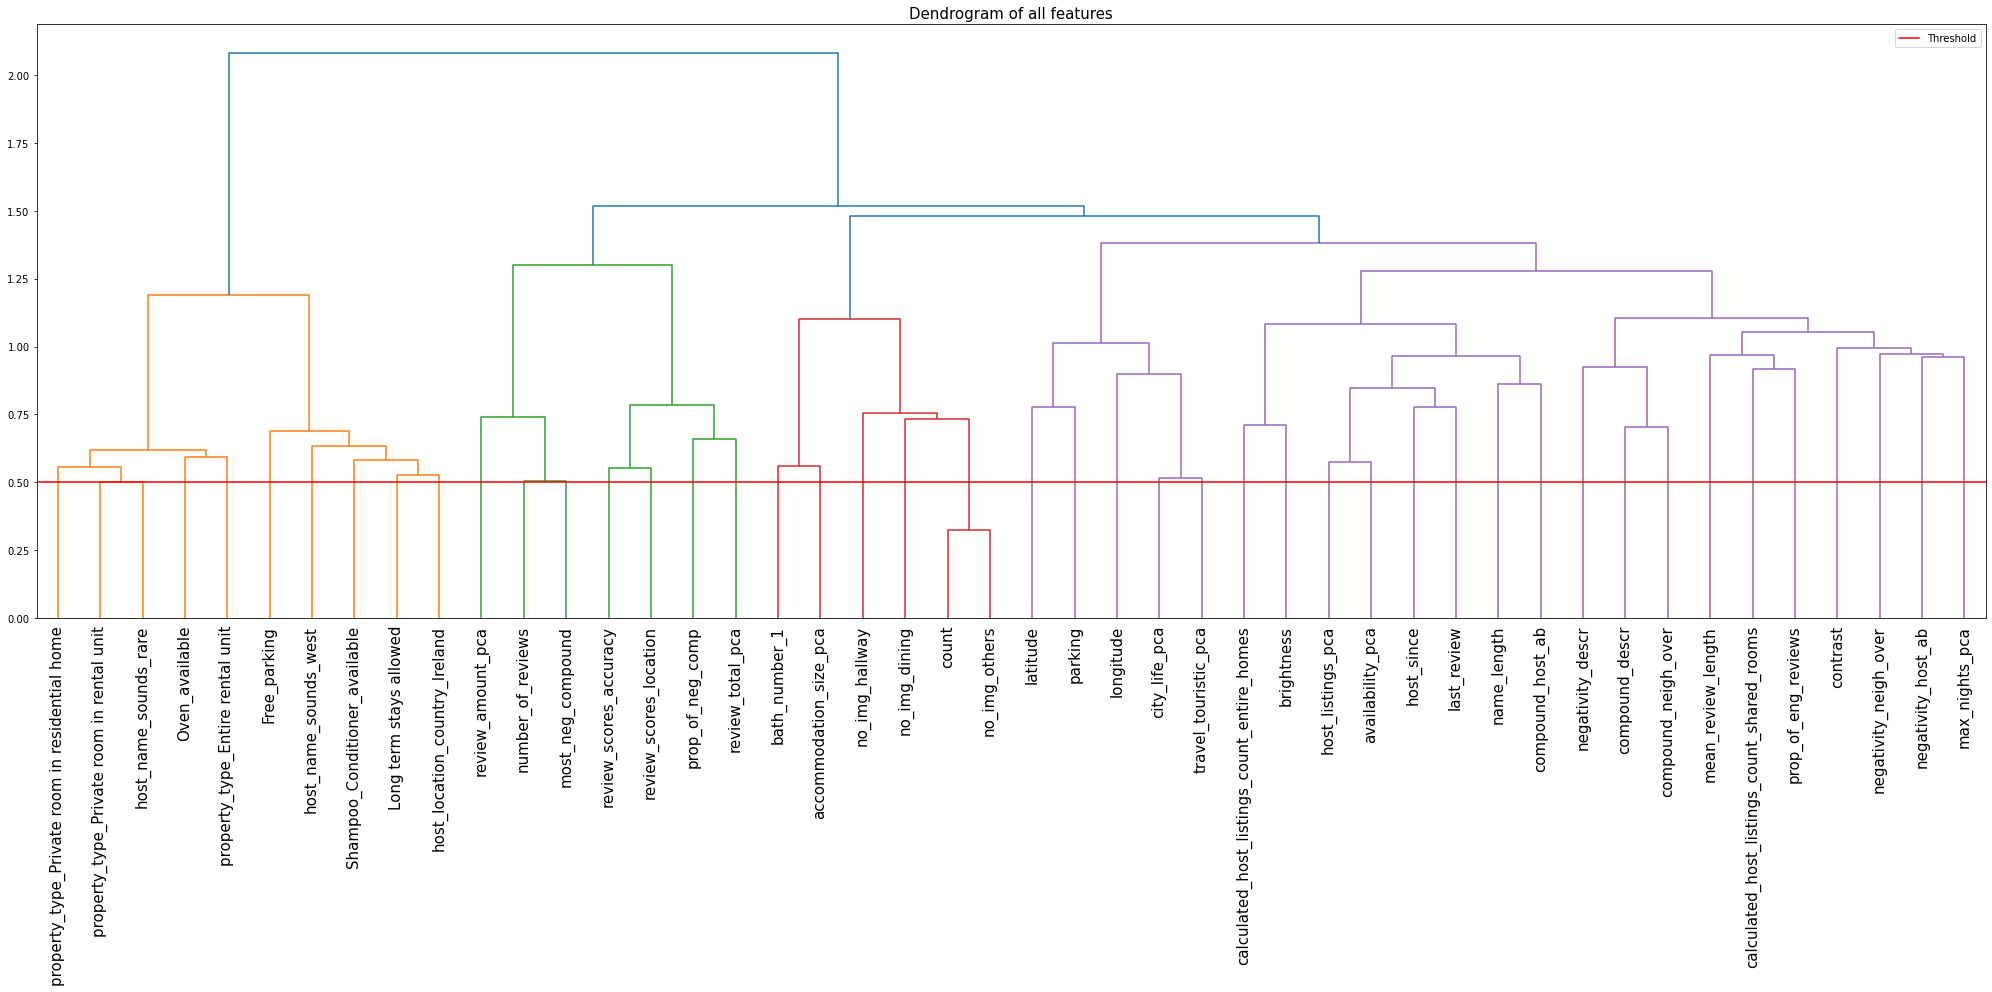

In [107]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr2 = C2
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr2)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col_compl, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

In [108]:
# count or no_img_others
listings_compl = drop_col(listings_compl, ["no_img_others"], regex = False)

# after next one
# count or no_img_dining
listings_compl = drop_col(listings_compl, ["no_img_dining"], regex = False)

In [113]:

listings_compl = drop_col(listings_compl, ["no_img_dining"], regex = False)

In [114]:
num_col_compl = [col for col in listings_compl if ~np.isin(listings_compl[col].unique(), [0, 1]).all()]
bin_col_compl = [col for col in listings_compl if np.isin(listings_compl[col].unique(), [0, 1]).all()]

In [115]:
numerical_df2 = listings_compl.filter(num_col_compl)
binary_df2 = listings_compl.filter(bin_col_compl)

PEARSON2 = np.abs(numerical_df2.corr())

# init matrix
A2 = np.zeros((len(bin_col_compl), len(bin_col_compl)))

for i, a in enumerate(bin_col_compl):
    for j, b in enumerate(bin_col_compl):
        A2[i,j] = jac(binary_df2[a], binary_df2[b])

JACCARD2 = pd.DataFrame(np.abs(A2))

binaries2 = binary_df2
numericals2 = numerical_df2

# init matrix
A3 = np.zeros((len(binaries2.columns), len(numericals2.columns)))
P2 = np.zeros((len(binaries2.columns), len(numericals2.columns)))

for i, a in enumerate(binaries2.columns):
    for j, b in enumerate(numericals2.columns):
        A3[i,j], P2[i,j] = stats.pointbiserialr(binaries2[a], numericals2[b])

BISERIAL2 = pd.DataFrame(np.abs(A3))

In [116]:
all_col_compl = bin_col_compl + num_col_compl
C2 = np.zeros((len(all_col_compl), len(all_col_compl)))

C2[:len(bin_col_compl),:len(bin_col_compl)] = JACCARD2
C2[len(bin_col_compl):,len(bin_col_compl):] = PEARSON2
C2[len(bin_col_compl):,:len(bin_col_compl)] = BISERIAL2.T
C2[:len(bin_col_compl),len(bin_col_compl):] = BISERIAL2

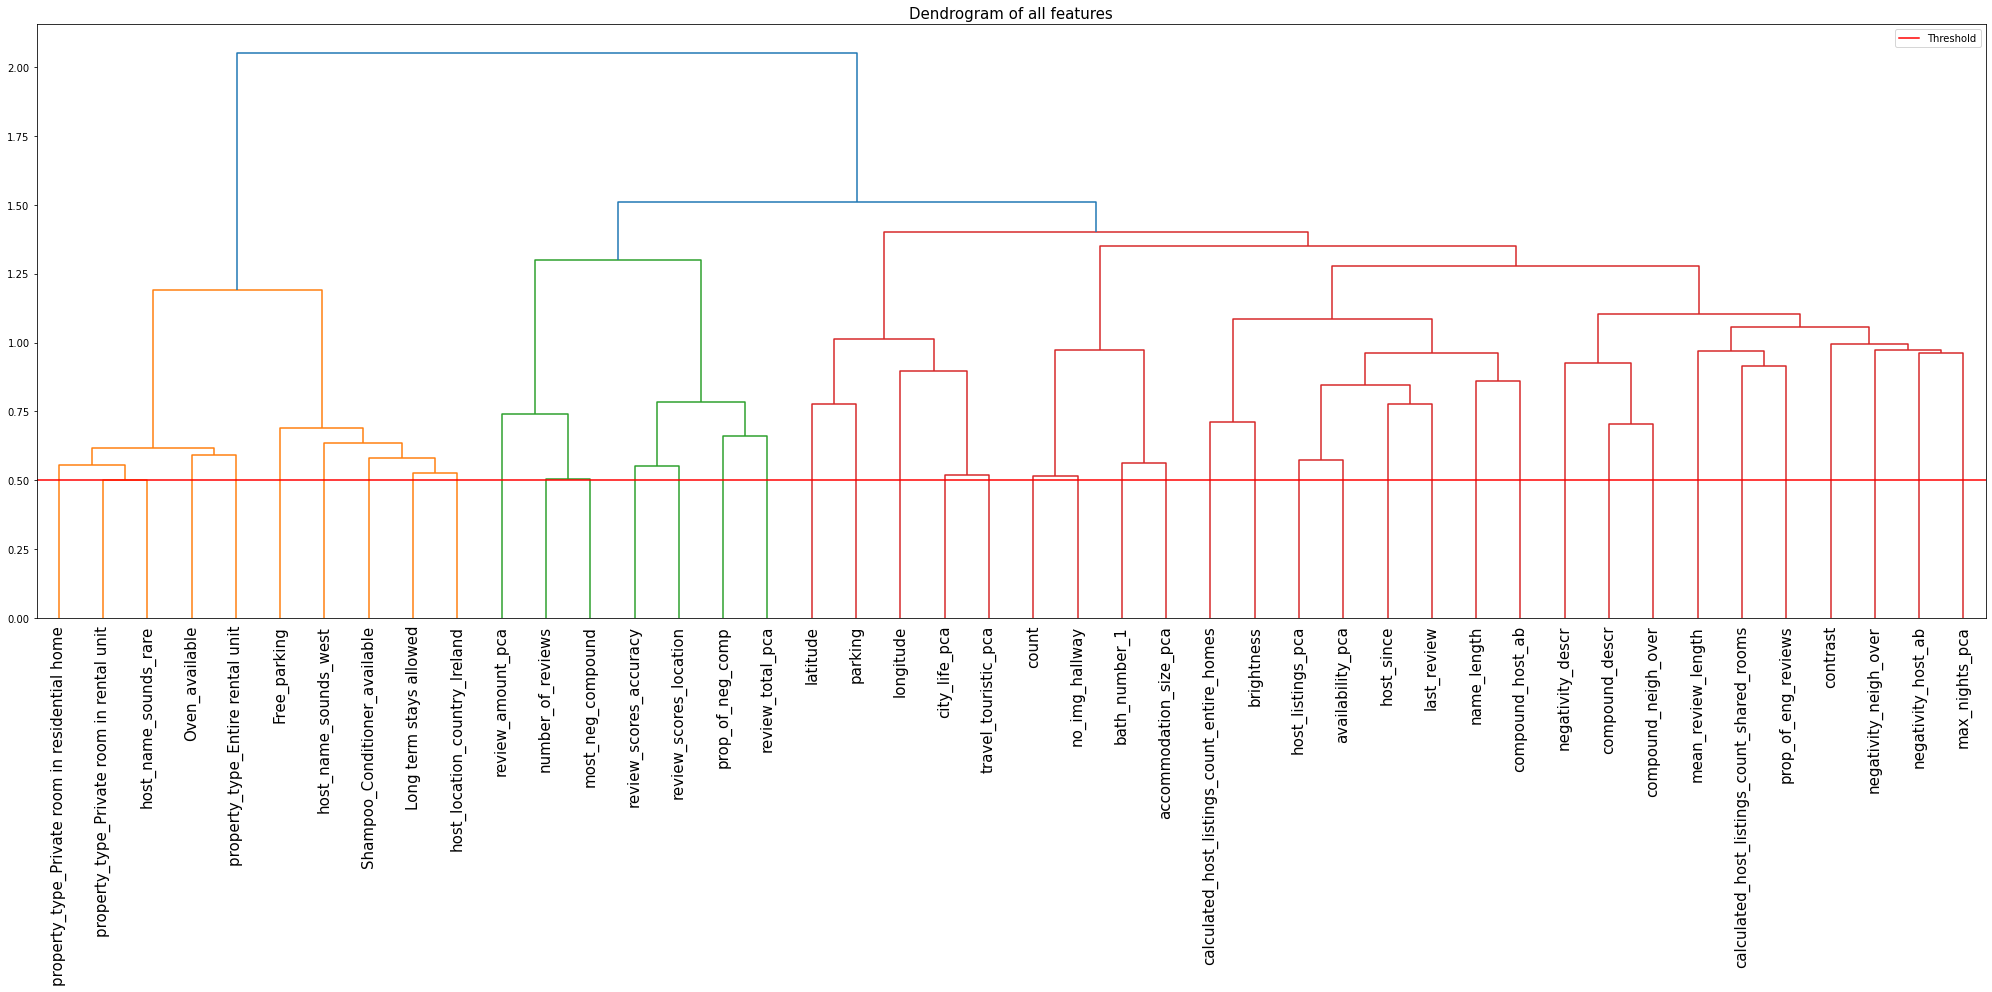

In [117]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr2 = C2
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr2)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col_compl, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

In [118]:
listings_compl.shape

(6840, 44)

# XGBoost Baseline Model

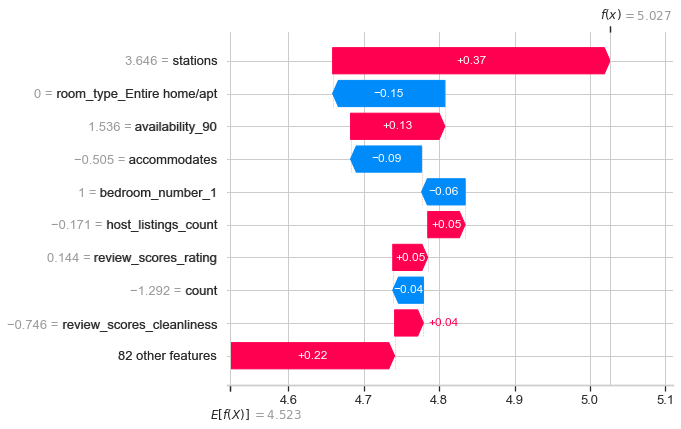

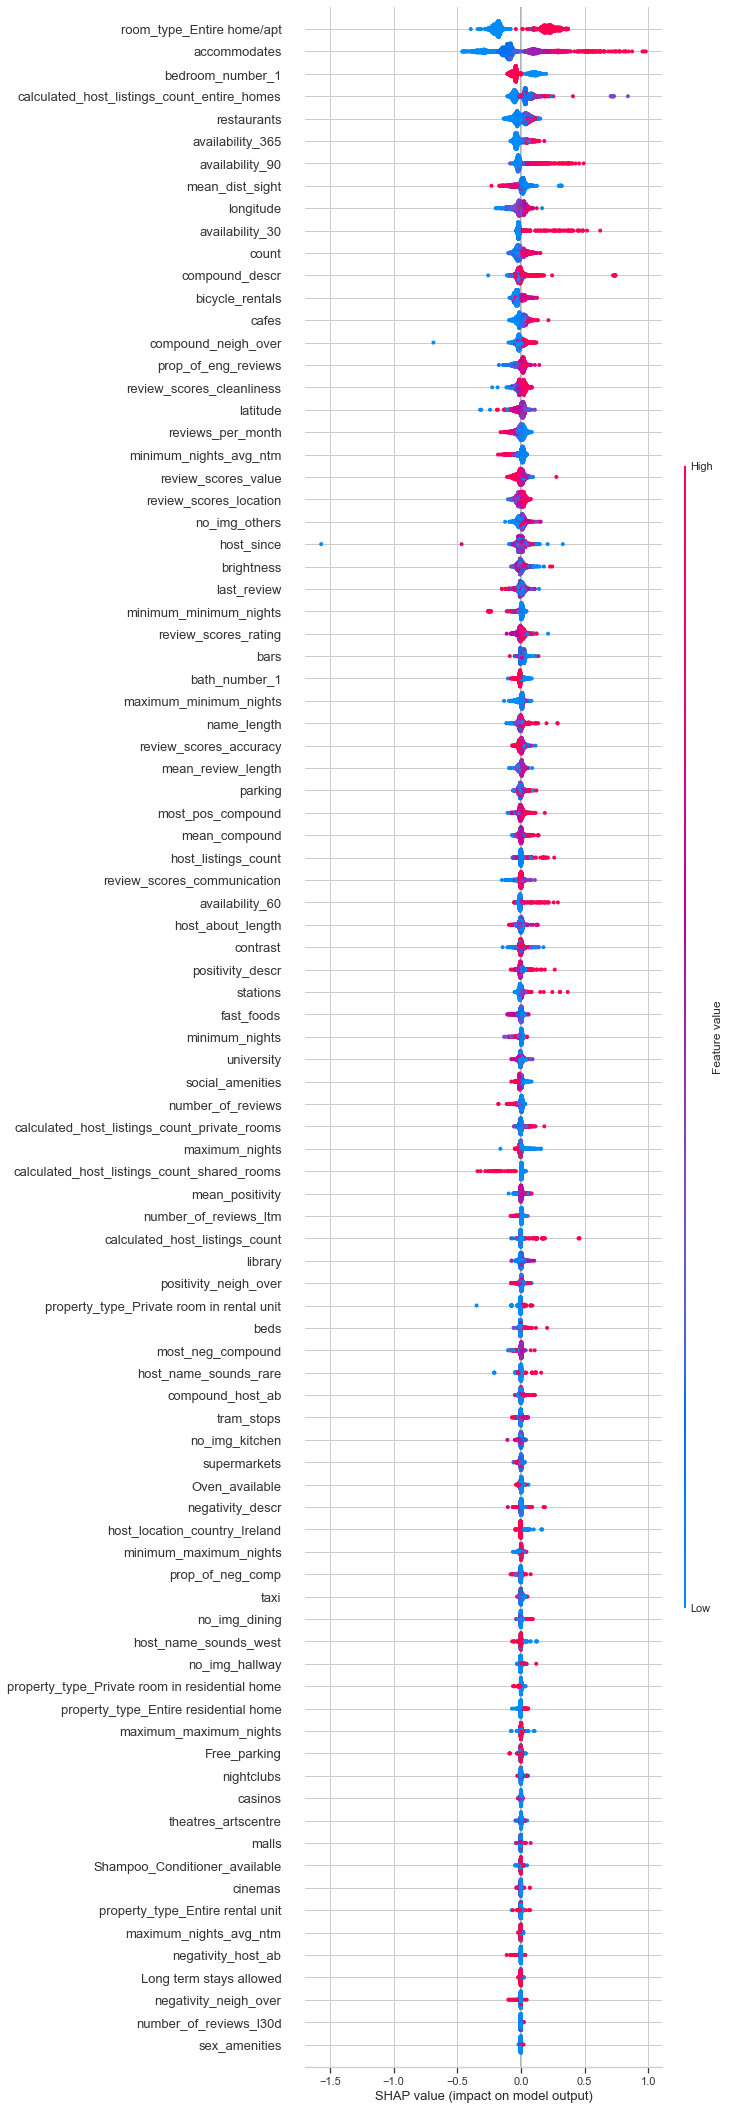

In [51]:
X_train, X_test, y_train, y_test = train_test_split(listings_compl, price_y, random_state = 123, test_size = 0.2)

# train an XGBoost model
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.explainers.Tree(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[2])
shap.plots.beeswarm(shap_values, max_display = len(listings.columns))

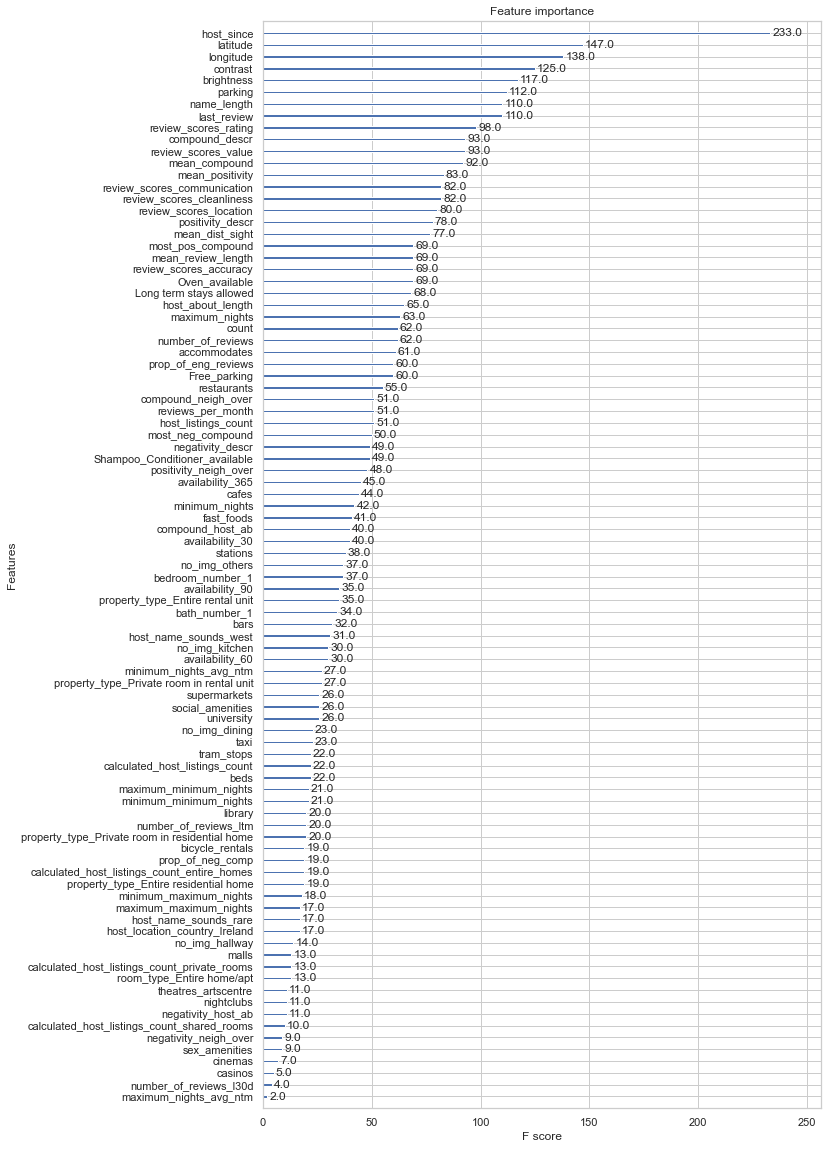

In [52]:
fig, ax = plt.subplots(1,1,figsize = (10,20))
xgboost.plot_importance(model, ax = ax)
plt.show()

# Final Selection

## Random Forest Model

In [37]:
len(price_y) == len(listings)

True

In [38]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings_compl, price_y, random_state = 123, test_size = 0.2)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.5624546697520705

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings_compl.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_57159/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


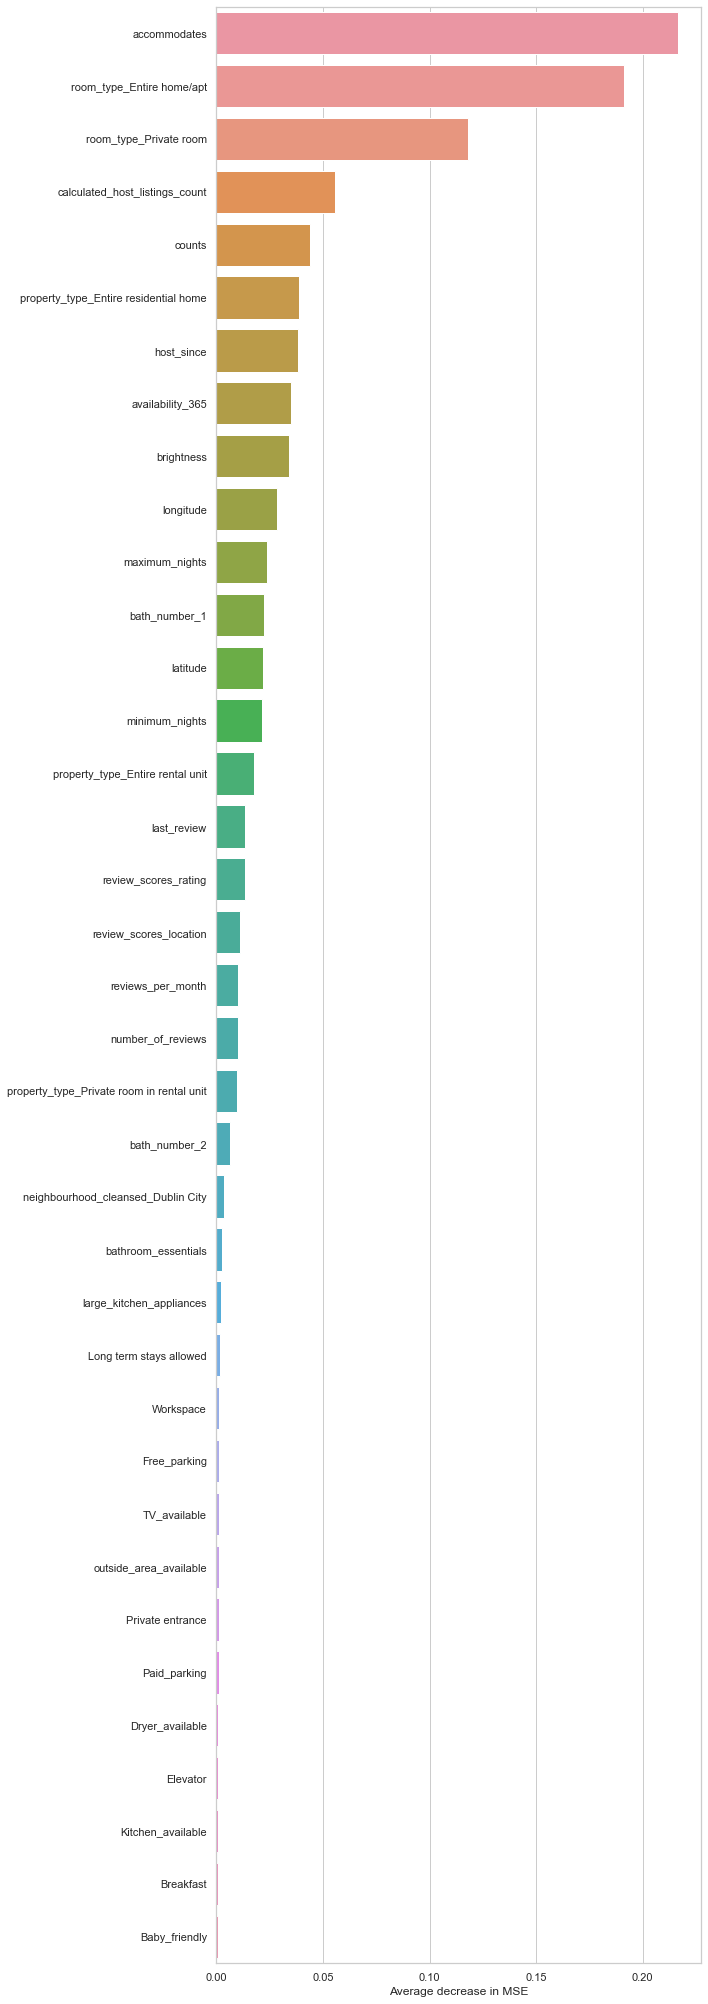

In [36]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

## Permutation

In [37]:
n_repeats = 10

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_57159/2623107921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


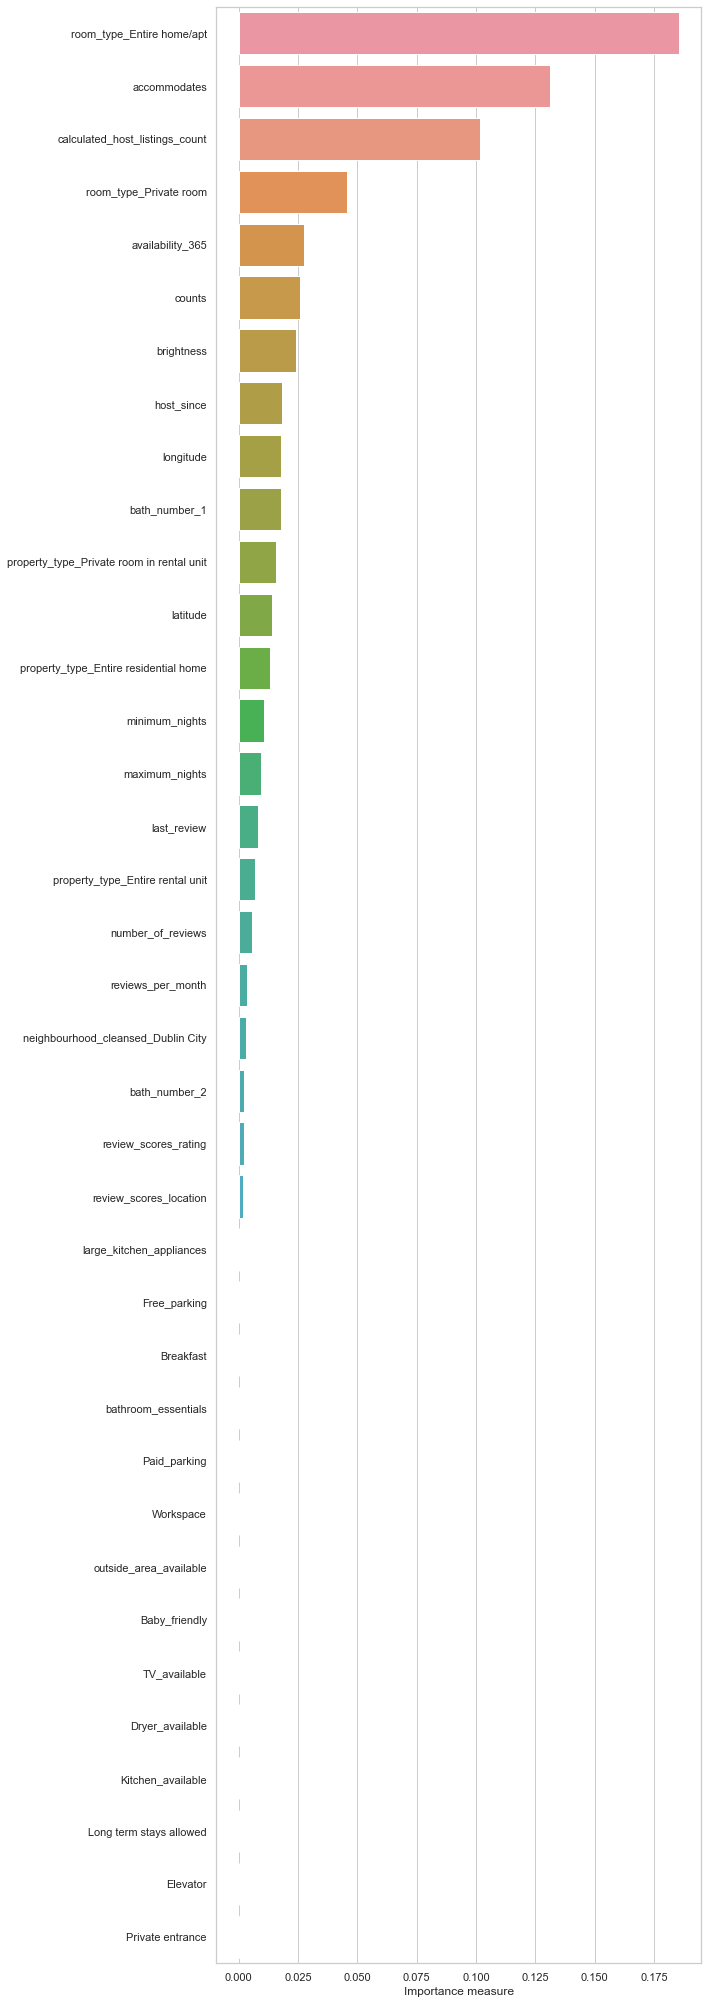

In [38]:
result = permutation_importance(forest, X_test, y_test, n_repeats = n_repeats, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.4243019480272783

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_57159/2182281270.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


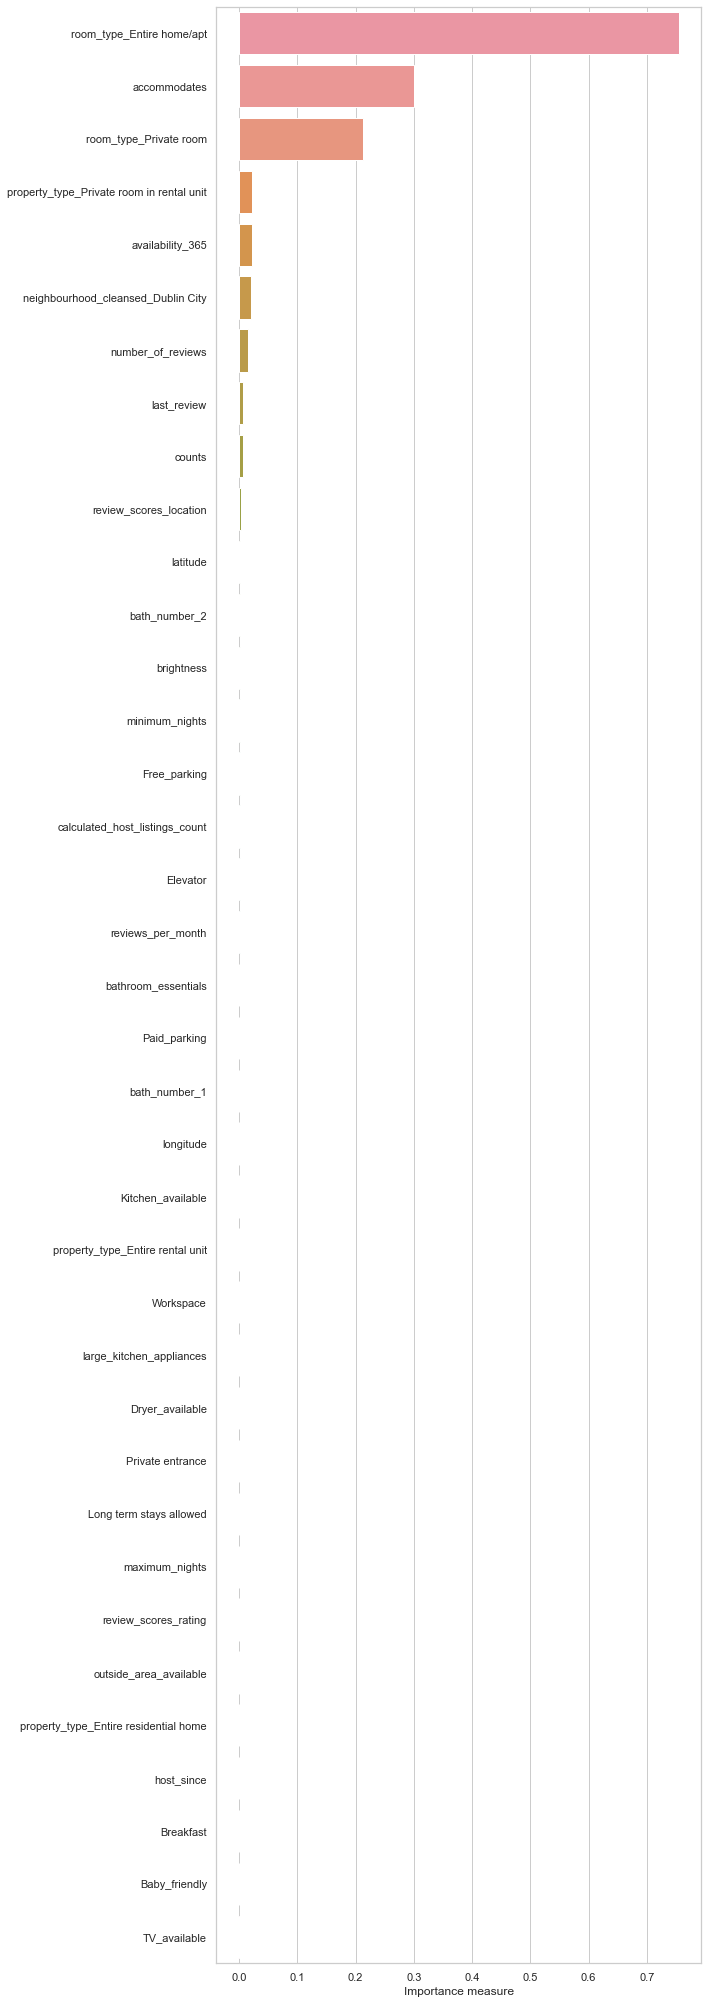

In [40]:
result = permutation_importance(reg, X_test, y_test, n_repeats=n_repeats, random_state=42)
lm_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = lm_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Boosting

In [39]:
params = {
    "n_estimators": 300,
    "max_depth": 3,
    "min_samples_split": 15,
    "learning_rate": 0.1,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.6775601982415574

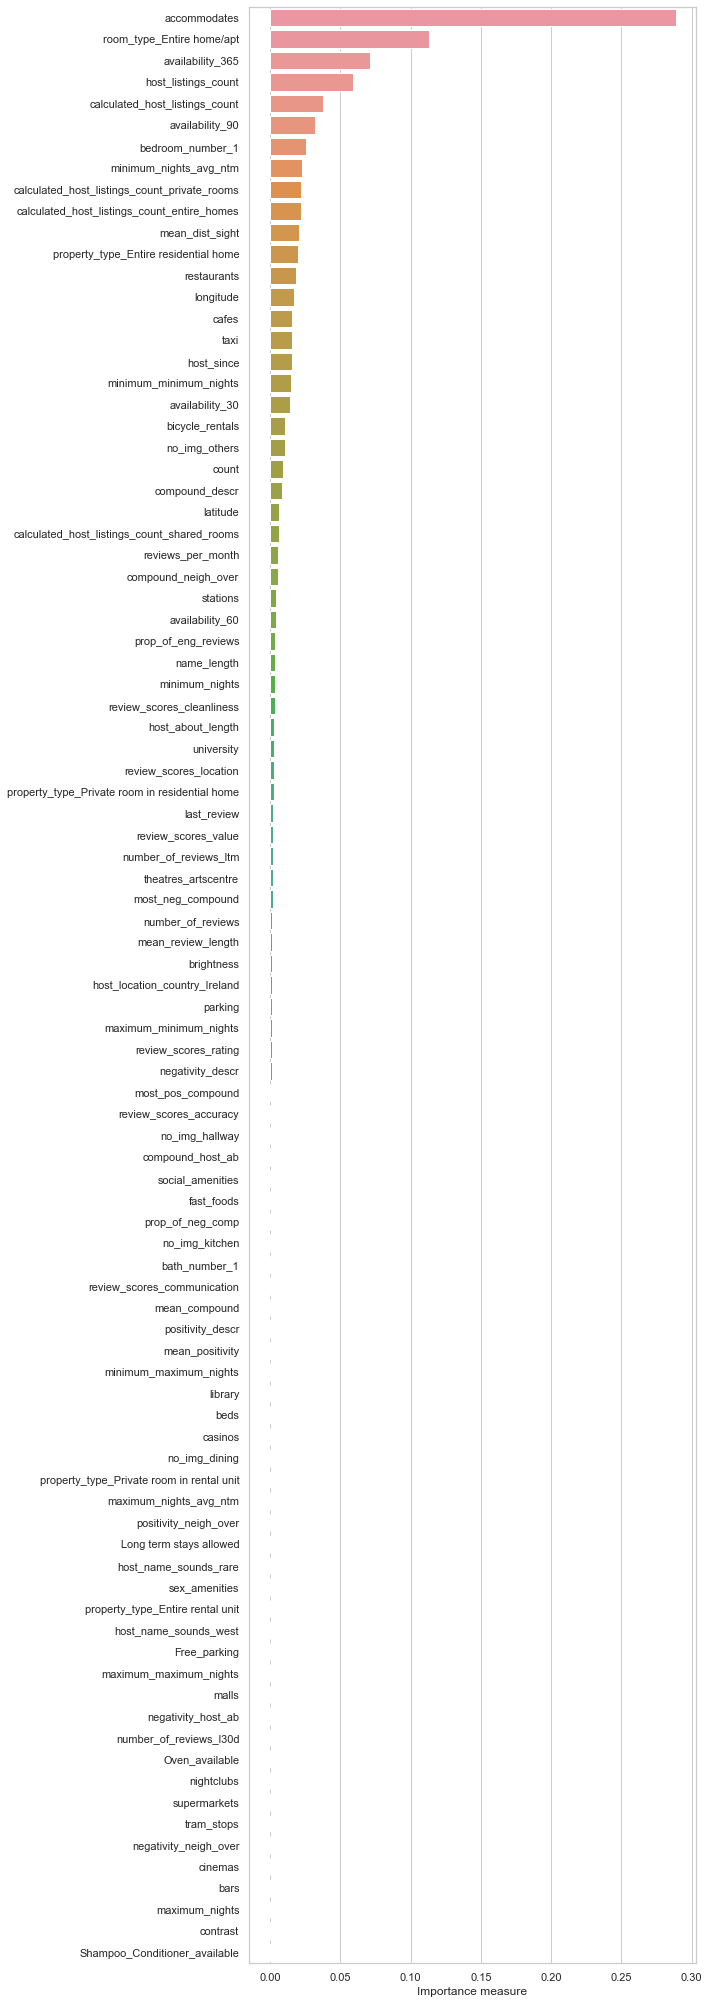

In [42]:
result = permutation_importance(reg, X_test, y_test, n_repeats=100, random_state=42, scoring = "r2")
boost_feature_importance = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = boost_feature_importance.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

In [43]:
importances = pd.DataFrame({"Forest": forest_importances, "Linear Regression": lm_importances, "Boosting": boost_feature_importance})

In [44]:
importances

,Forest,Linear Regression,Boosting
Breakfast,0.000214,-0.000632,-0.000378
Elevator,-0.000014,0.000954,-0.000045
Long term stays allowed,0.000002,0.000034,-0.000104
Private entrance,-0.000064,0.000123,-0.000058
Workspace,0.000097,0.000387,-0.000011
Dryer_available,0.000016,0.000157,-0.000007
Kitchen_available,0.000011,0.000508,0.000200
neighbourhood_cleansed_Dublin City,0.003224,0.020600,0.003578
property_type_Entire rental unit,0.006932,0.000398,0.000098
property_type_Entire residential home,0.013301,-0.000250,0.036090


In [45]:
importances.mean(axis = 1).sort_values(ascending=False)

room_type_Entire home/apt                    4.113504e-01
accommodates                                 2.580741e-01
calculated_host_listings_count               1.554032e-01
room_type_Private room                       9.435167e-02
availability_365                             5.506260e-02
latitude                                     1.956704e-02
property_type_Entire residential home        1.638061e-02
counts                                       1.504086e-02
longitude                                    1.375921e-02
property_type_Private room in rental unit    1.318567e-02
host_since                                   1.290592e-02
minimum_nights                               1.123159e-02
number_of_reviews                            1.113015e-02
brightness                                   1.080247e-02
neighbourhood_cleansed_Dublin City           9.133709e-03
last_review                                  8.677700e-03
bath_number_1                                6.785462e-03
review_scores_

In [37]:
model.score(X_test, y_test)

0.6583689569425414

In [49]:
import tensorflow as tf
from tensorflow import keras

Init Plugin
Init Graph Optimizer
Init Kernel


In [47]:
X_test.shape

(1368, 37)

In [71]:
num_features = X_train.shape[1]

inputs_feat = keras.layers.Input(shape = num_features)
x = keras.layers.Dense(5000, activation = "relu")(inputs_feat)
x = keras.layers.Dense(1000, activation = "relu")(inputs_feat)

out = keras.layers.Dense(1)(x)
model = keras.Model(inputs_feat, out)

In [72]:
model.compile("adam", "mse")
model.fit(X_train, y_train, batch_size = 32, epochs = 20)

Epoch 1/20
 19/171 [==>...........................] - ETA: 1s - loss: 6.6631 

2022-01-09 19:41:09.902282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 1s 6ms/step - loss: 1.3507
Epoch 2/20
171/171 [==============================] - 1s 6ms/step - loss: 0.3936
Epoch 3/20
171/171 [==============================] - 1s 6ms/step - loss: 0.3286
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2982
Epoch 5/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2758
Epoch 6/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2657
Epoch 7/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2533
Epoch 8/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2779
Epoch 9/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2252
Epoch 10/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2219
Epoch 11/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2091
Epoch 12/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2009
Epoch 13/20
171/171 [===============

In [67]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  return r2

Parameter XGBoost
- eta (0.01-0.2)
- gamma - minimum loss reduction for split (0, infty)
- max depth - Tiefe des Baums, je tiefer desto eher overfitting (3-10)
- min_child_weight: Summe der Gewichte in den Leaves. Regelt overfitting (0, infty)
- subsample - Anteil der Beobachtungen den Tree zufällig zugewiesen bekommt. Regel overfitting (0.5-1)
- lambda - l2 Regularisierung der Gewichte